In [1]:
import math
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import tifffile
import torchvision.transforms.functional as TF
import torch
from pathlib import Path
from collections import Counter

from einops import rearrange


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mip.utils import listfiles, extract_ome_tiff, R_CHANNEL_MAPPING, make_pseudo, display_region

In [5]:
out_dir = '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3'
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [6]:
fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3',
                      regex=r'.pt$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT110B1_S1H4_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT171B1-S1H9A1-4_left_05122023_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT171B1-S1H9A1-4_right_05122023_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT206B1_H1_06252022_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT206B1_H1_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT206B1_S1H2L4_20221028_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT243B1-S1H4A4_04192023_results.pt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3/HT243B1-S1H4A4_left_05122023_resul

In [7]:
sample_to_fp = {fp.split('/')[-1].split('_results')[0]:fp for fp in fps}

In [8]:
sample_to_tables = {}
sample_to_thumbnails = {}
for fp in fps:
    sample = fp.split('/')[-1].split('_results')[0]
    print(sample)
    
    obj = torch.load(fp)
    sample_to_tables[sample] = obj['tables']
    sample_to_thumbnails[sample] = obj['images']['thumbnail']
sample_to_tables.keys()

HT110B1_S1H4
HT171B1-S1H9A1-4_left_05122023
HT171B1-S1H9A1-4_right_05122023
HT206B1_H1_06252022
HT206B1_H1
HT206B1_S1H2L4_20221028
HT243B1-S1H4A4_04192023
HT243B1-S1H4A4_left_05122023
HT243B1-S1H4A4_right_05122023
HT243B1_S1H4
HT271B1-S1H6A5_04192023
HT271B1-S1H6A5_left_05122023
HT271B1-S1H6A5_right_05122023
HT297B1_H1_08042022
HT305B1_S1H1
HT308B1-S1H5A4_04192023
HT308B1-S1H5A4_left_05122023
HT308B1-S1H5A4_right_05122023
HT323B1_H1A1
HT323B1_H1A4
HT323B1_H1_08042022
HT323B1_H3
HT339B1_H1A1
HT339B1_H2A1
HT339B1_H4A4
HT342C1_Th1K4A1_section1_03042022
HT342C1_Th1K4A1_section2_03042022
HT347C1_Th1K2A1_section1_03042022
HT347C1_Th1K2A1_section2_03042022
HT365B1_S1H1_02132023
HT397B1_H2A2
HT397B1_H3A1
HT397B1_S1H1A3U22_04122023
HT397B1_S1H1A3U31_04062023
HT397B1_U12_03172023
HT397B1_U2_03162023
HT413C1-K2_04262023
HT427P1_S1H1A3_20221020
HT480B1_S1H2_R001
HT480B1_S1H2_R002
HT488C1-Th1K1Fp1-U14_041823
HT488C1-Th1K1Fp1-U2_041323
HT553P1-H2_04262023
HT565B1-H2_04262023


dict_keys(['HT110B1_S1H4', 'HT171B1-S1H9A1-4_left_05122023', 'HT171B1-S1H9A1-4_right_05122023', 'HT206B1_H1_06252022', 'HT206B1_H1', 'HT206B1_S1H2L4_20221028', 'HT243B1-S1H4A4_04192023', 'HT243B1-S1H4A4_left_05122023', 'HT243B1-S1H4A4_right_05122023', 'HT243B1_S1H4', 'HT271B1-S1H6A5_04192023', 'HT271B1-S1H6A5_left_05122023', 'HT271B1-S1H6A5_right_05122023', 'HT297B1_H1_08042022', 'HT305B1_S1H1', 'HT308B1-S1H5A4_04192023', 'HT308B1-S1H5A4_left_05122023', 'HT308B1-S1H5A4_right_05122023', 'HT323B1_H1A1', 'HT323B1_H1A4', 'HT323B1_H1_08042022', 'HT323B1_H3', 'HT339B1_H1A1', 'HT339B1_H2A1', 'HT339B1_H4A4', 'HT342C1_Th1K4A1_section1_03042022', 'HT342C1_Th1K4A1_section2_03042022', 'HT347C1_Th1K2A1_section1_03042022', 'HT347C1_Th1K2A1_section2_03042022', 'HT365B1_S1H1_02132023', 'HT397B1_H2A2', 'HT397B1_H3A1', 'HT397B1_S1H1A3U22_04122023', 'HT397B1_S1H1A3U31_04062023', 'HT397B1_U12_03172023', 'HT397B1_U2_03162023', 'HT413C1-K2_04262023', 'HT427P1_S1H1A3_20221020', 'HT480B1_S1H2_R001', 'HT480B1_

In [13]:
samples = sorted(sample_to_tables.keys())
samples

['HT110B1_S1H4',
 'HT171B1-S1H9A1-4_left_05122023',
 'HT171B1-S1H9A1-4_right_05122023',
 'HT206B1_H1',
 'HT206B1_H1_06252022',
 'HT206B1_S1H2L4_20221028',
 'HT243B1-S1H4A4_04192023',
 'HT243B1-S1H4A4_left_05122023',
 'HT243B1-S1H4A4_right_05122023',
 'HT243B1_S1H4',
 'HT271B1-S1H6A5_04192023',
 'HT271B1-S1H6A5_left_05122023',
 'HT271B1-S1H6A5_right_05122023',
 'HT297B1_H1_08042022',
 'HT305B1_S1H1',
 'HT308B1-S1H5A4_04192023',
 'HT308B1-S1H5A4_left_05122023',
 'HT308B1-S1H5A4_right_05122023',
 'HT323B1_H1A1',
 'HT323B1_H1A4',
 'HT323B1_H1_08042022',
 'HT323B1_H3',
 'HT339B1_H1A1',
 'HT339B1_H2A1',
 'HT339B1_H4A4',
 'HT342C1_Th1K4A1_section1_03042022',
 'HT342C1_Th1K4A1_section2_03042022',
 'HT347C1_Th1K2A1_section1_03042022',
 'HT347C1_Th1K2A1_section2_03042022',
 'HT365B1_S1H1_02132023',
 'HT397B1_H2A2',
 'HT397B1_H3A1',
 'HT397B1_S1H1A3U22_04122023',
 'HT397B1_S1H1A3U31_04062023',
 'HT397B1_U12_03172023',
 'HT397B1_U2_03162023',
 'HT413C1-K2_04262023',
 'HT427P1_S1H1A3_20221020',
 'H

In [134]:
samples = [
    'HT110B1_S1H4',
    'HT171B1-S1H9A1-4_left_05122023',
    'HT171B1-S1H9A1-4_right_05122023',
    'HT206B1_H1',
    'HT206B1_H1_06252022',
    'HT206B1_S1H2L4_20221028',
    'HT243B1-S1H4A4_04192023',
    'HT243B1-S1H4A4_left_05122023',
    'HT243B1-S1H4A4_right_05122023',
    'HT243B1_S1H4',
    'HT271B1-S1H6A5_04192023',
    'HT271B1-S1H6A5_left_05122023',
    'HT271B1-S1H6A5_right_05122023',
#     'HT297B1_H1_08042022',
#     'HT305B1_S1H1',
    'HT308B1-S1H5A4_04192023',
    'HT308B1-S1H5A4_left_05122023',
    'HT308B1-S1H5A4_right_05122023',
    'HT323B1_H1A1',
    'HT323B1_H1A4',
    'HT323B1_H1_08042022',
    'HT323B1_H3',
#     'HT339B1_H1A1',
#     'HT339B1_H2A1',
#     'HT339B1_H4A4',
#     'HT342C1_Th1K4A1_section1_03042022',
#     'HT342C1_Th1K4A1_section2_03042022',
#     'HT347C1_Th1K2A1_section1_03042022',
#     'HT347C1_Th1K2A1_section2_03042022',
    'HT365B1_S1H1_02132023',
    'HT397B1_H2A2',
    'HT397B1_H3A1',
    'HT397B1_S1H1A3U22_04122023',
    'HT397B1_S1H1A3U31_04062023',
    'HT397B1_U12_03172023',
    'HT397B1_U2_03162023',
#     'HT413C1-K2_04262023',
#     'HT427P1_S1H1A3_20221020',
    'HT480B1_S1H2_R001',
    'HT480B1_S1H2_R002',
#     'HT488C1-Th1K1Fp1-U14_041823',
#     'HT488C1-Th1K1Fp1-U2_041323',
#     'HT553P1-H2_04262023',
    'HT565B1-H2_04262023'
]

In [135]:
len(samples)

30

In [136]:
clf_probs = pd.read_csv(
    '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/classification_v3/results/probs.txt',
    sep='\t', index_col=0
)
clf_probs['predicted_label'] = clf_probs.columns[clf_probs.values.argmax(1)].to_list()
clf_probs.columns = [f'probability_{c}' if c!='predicted_label' else c for c in clf_probs.columns]

clf_probs

probability_artifact  probability_dcis  \
region_id                                                        
HT110B1_S1H4_1                  2.474620e-05      9.998623e-01   
HT110B1_S1H4_10                 1.403064e-06      9.023645e-06   
HT110B1_S1H4_100                3.269456e-06      3.352918e-05   
HT110B1_S1H4_101                2.608848e-07      1.441338e-07   
HT110B1_S1H4_102                1.719461e-06      5.704798e-06   
...                                      ...               ...   
HT565B1-H2_04262023_89          9.198514e-04      1.501836e-01   
HT565B1-H2_04262023_9           8.197178e-06      9.661377e-05   
HT565B1-H2_04262023_90          3.312618e-05      1.948579e-04   
HT565B1-H2_04262023_91          5.769879e-06      9.999706e-01   
HT565B1-H2_04262023_92          4.644287e-04      5.946973e-04   

                        probability_idc  probability_normal predicted_label  
region_id                                                                    
HT110B1_S1H4_1                 0.000075        3.838993e-05            dcis  
HT110B1_S1H4_10                0.999989        6.770355e-07             idc  
HT110B1_S1H4_100               0.999957        5.890300e-06             idc  
HT110B1_S1H4_101               1.000000        3.697922e-08             idc  
HT110B1_S1H4_102               0.999991        1.609826e-06             idc  
...                                 ...                 ...             ...  
HT565B1-H2_04262023_89         0.005554        8.433428e-01          normal  
HT565B1-H2_04262023_9          0.999893        2.155998e-06             idc  
HT565B1-H2_04262023_90         0.000107        9.996650e-01          normal  
HT565B1-H2_04262023_91         0.000004        1.983533e-05            dcis  
HT565B1-H2_04262023_92         0.998926        1.434539e-05             idc  

[9950 rows x 5 columns]

In [172]:
type_to_combined = {}
for k in next(iter(sample_to_tables.values())).keys():
    combined = None
    for s, tables in sample_to_tables.items():
        if s in samples:
            df = tables[k].copy()
            df.index = [f'{s}_{x}' for x in df.index]
            df.index.name = 'label'
            df['sample'] = s
            
            # z-score marker intensity
            for c in df.columns:
                if 'marker_intensity' in c:
                    vals = df[c]
                    vals -= vals.mean()
                    vals /= vals.std()
                    vals -= vals.min()
                    df[c] = vals

            df = df.transpose()

            if combined is None:
                combined = df
            else:
                combined = pd.merge(combined, df, left_index=True, right_index=True, how='outer')
    combined = combined.transpose()
    combined.index.name = 'label'
    
    combined = pd.merge(combined, clf_probs, left_index=True, right_index=True, how='left')
    
    type_to_combined[k] = combined

In [173]:
type_to_combined.keys()

dict_keys(['region', 'ductal', 'myoepi', 'boundary', 'expanded'])

In [174]:
type_to_combined['region']

area     c1     c2 cell_type_fraction_B cell  \
label                                                                    
HT110B1_S1H4_1           12964   4573   4674                       0.0   
HT110B1_S1H4_2          114536   5320   5797                       0.0   
HT110B1_S1H4_3           11542   6471   6580                       0.0   
HT110B1_S1H4_4           31296   6324   6511                       0.0   
HT110B1_S1H4_5           17383   5993   6128                       0.0   
...                        ...    ...    ...                       ...   
HT565B1-H2_04262023_88   26350  12370  12667                       NaN   
HT565B1-H2_04262023_89   85158   5211   5728                       NaN   
HT565B1-H2_04262023_90   14999   8662   8818                       NaN   
HT565B1-H2_04262023_91  326815   3725   5110                       NaN   
HT565B1-H2_04262023_92  207613   9069  10263                       NaN   

                       cell_type_fraction_CD4 T cell  \
label                                                  
HT110B1_S1H4_1                                   NaN   
HT110B1_S1H4_2                                   NaN   
HT110B1_S1H4_3                                   NaN   
HT110B1_S1H4_4                                   NaN   
HT110B1_S1H4_5                                   NaN   
...                                              ...   
HT565B1-H2_04262023_88                           0.0   
HT565B1-H2_04262023_89                           0.0   
HT565B1-H2_04262023_90                      0.111111   
HT565B1-H2_04262023_91                      0.005155   
HT565B1-H2_04262023_92                           0.0   

                       cell_type_fraction_CD8 T cell  \
label                                                  
HT110B1_S1H4_1                                   0.0   
HT110B1_S1H4_2                              0.007299   
HT110B1_S1H4_3                                   0.0   
HT110B1_S1H4_4                                   0.0   
HT110B1_S1H4_5                                   0.0   
...                                              ...   
HT565B1-H2_04262023_88                           0.0   
HT565B1-H2_04262023_89                      0.012346   
HT565B1-H2_04262023_90                      0.444444   
HT565B1-H2_04262023_91                      0.015464   
HT565B1-H2_04262023_92                           0.0   

                       cell_type_fraction_Endothelial  \
label                                                   
HT110B1_S1H4_1                                    NaN   
HT110B1_S1H4_2                                    NaN   
HT110B1_S1H4_3                                    NaN   
HT110B1_S1H4_4                                    NaN   
HT110B1_S1H4_5                                    NaN   
...                                               ...   
HT565B1-H2_04262023_88                       0.111111   
HT565B1-H2_04262023_89                       0.493827   
HT565B1-H2_04262023_90                       0.037037   
HT565B1-H2_04262023_91                        0.21134   
HT565B1-H2_04262023_92                            0.0   

                       cell_type_fraction_Epithelial  \
label                                                  
HT110B1_S1H4_1                                   1.0   
HT110B1_S1H4_2                              0.985401   
HT110B1_S1H4_3                                   1.0   
HT110B1_S1H4_4                                   1.0   
HT110B1_S1H4_5                                   1.0   
...                                              ...   
HT565B1-H2_04262023_88                      0.851852   
HT565B1-H2_04262023_89                      0.395062   
HT565B1-H2_04262023_90                      0.407407   
HT565B1-H2_04262023_91                      0.675258   
HT565B1-H2_04262023_92                           1.0   

                       cell_type_fraction_Immune  \
label                                              
HT110B1_S1H4_1                

In [175]:
sorted(type_to_combined['region'].columns)

['area',
 'c1',
 'c2',
 'cell_type_fraction_B cell',
 'cell_type_fraction_CD4 T cell',
 'cell_type_fraction_CD8 T cell',
 'cell_type_fraction_Endothelial',
 'cell_type_fraction_Epithelial',
 'cell_type_fraction_Immune',
 'cell_type_fraction_Macrophage - M1',
 'cell_type_fraction_Stroma',
 'cell_type_fraction_Treg',
 'cell_type_fraction_Unlabeled',
 'col',
 'compactness',
 'marker_fraction_CD11b',
 'marker_fraction_CD163',
 'marker_fraction_CD20',
 'marker_fraction_CD31',
 'marker_fraction_CD3e',
 'marker_fraction_CD4',
 'marker_fraction_CD45',
 'marker_fraction_CD68',
 'marker_fraction_CD8',
 'marker_fraction_CK14',
 'marker_fraction_CK17',
 'marker_fraction_CK5',
 'marker_fraction_E-cadherin',
 'marker_fraction_FOXP3',
 'marker_fraction_Ki67',
 'marker_fraction_Pan-Cytokeratin',
 'marker_fraction_Podoplanin',
 'marker_fraction_SMA',
 'marker_intensity_BCA1',
 'marker_intensity_Bap1',
 'marker_intensity_CD11b',
 'marker_intensity_CD11c',
 'marker_intensity_CD138',
 'marker_intensity_CD

In [176]:
scale = .1
region_to_bbox = {reg:(r1, c1, r2, c2) for reg, r1, c1, r2, c2 in zip(
                    type_to_combined['boundary'].index.to_list(),
                    type_to_combined['boundary']['r1'], type_to_combined['boundary']['c1'],
                    type_to_combined['boundary']['r2'], type_to_combined['boundary']['c2'])}
region_to_bbox_thumbnail = {k:(int(r1 * scale), int(c1 * scale), int(r2 * scale), int(c2 * scale))
                           for k, (r1, c1, r2, c2) in region_to_bbox.items()}

In [177]:
def display_legend(cmap, n=50):
    fig, axs = plt.subplots(nrows=1, ncols=len(cmap))
    for i, (name, c) in enumerate(cmap.items()):
        ax = axs[i]
        rect = np.zeros((n, n, 3), dtype=np.float32)
        rect[:, :] = c
        ax.imshow(rect)
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])
        
def get_display_image(s, labeled, region_to_bbox, vmax=None,
                      color='area', cmap='viridis', df=None, order=None):
    if df is None:
        df = combined

    f = df[df['sample']==s]
    f.index = [x.split('_')[-1] for x in f.index]
    rbbox = {reg.split('_')[-1]:tup for reg, tup in region_to_bbox.items() if s in reg}
    region_to_val = {reg:v
                     for reg, v in zip(f.index, f[color])}
    if region_to_val:
        rgba = display_region(labeled, region_to_val, rbbox, cmap=cmap, vmax=vmax, cats=order)
    else:
        rgba = np.ones((labeled.shape[0], labeled.shape[1], 4))
    return rgba
        
def show_regions(key, feat, cmap=None, vmax=None, ncols=6):
    nrows = (len(samples) // ncols) + 1
    
    df = type_to_combined[key]
    
    vals = df[feat]
    try:
        float(vals[0])
        order = None
        is_numeric = True
    except:
        order = sorted(set(vals))
        is_numeric = False
    
    fig, axs = plt.subplots(nrows=nrows if nrows > 1 else 2, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    stack = [(k, v) for k, v in sample_to_thumbnails.items() if k in samples]
    for i in range(nrows):
        for j in range(ncols):
            ax = axs[i, j]
            if len(stack):
                s, thumbnails = stack.pop(0)
                labeled = thumbnails['labeled']['region']
                
                img = get_display_image(s, labeled, region_to_bbox_thumbnail,
                                        color=feat, df=df, cmap=cmap, order=order, vmax=vmax)
                ax.imshow(img)
                ax.set_title(s)
            ax.axis('equal')
            ax.axis('off') 
            
    plt.show()
    
    if is_numeric:
        pass
    else:
        cmap = {k:v 
                for k, v in zip(sorted(set(vals)), sns.color_palette('tab10' if cmap is None else cmap))}
        display_legend(cmap)
        plt.show()

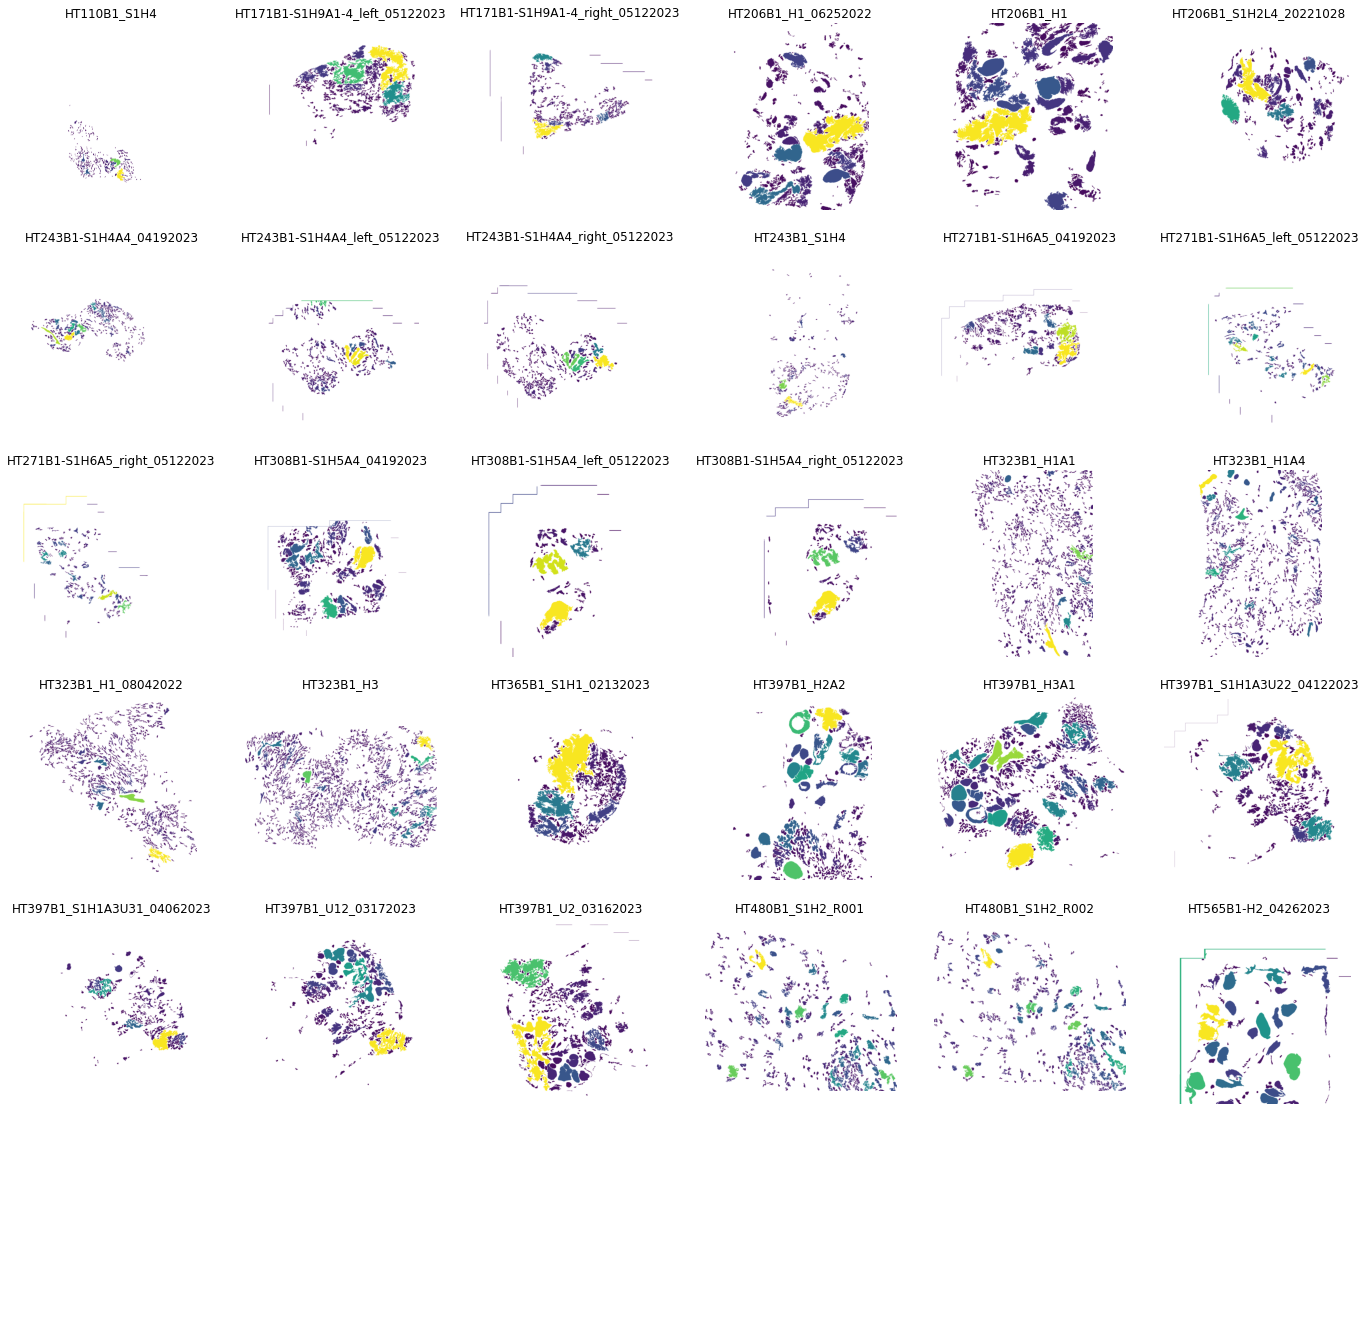

In [143]:
show_regions('region', 'area')

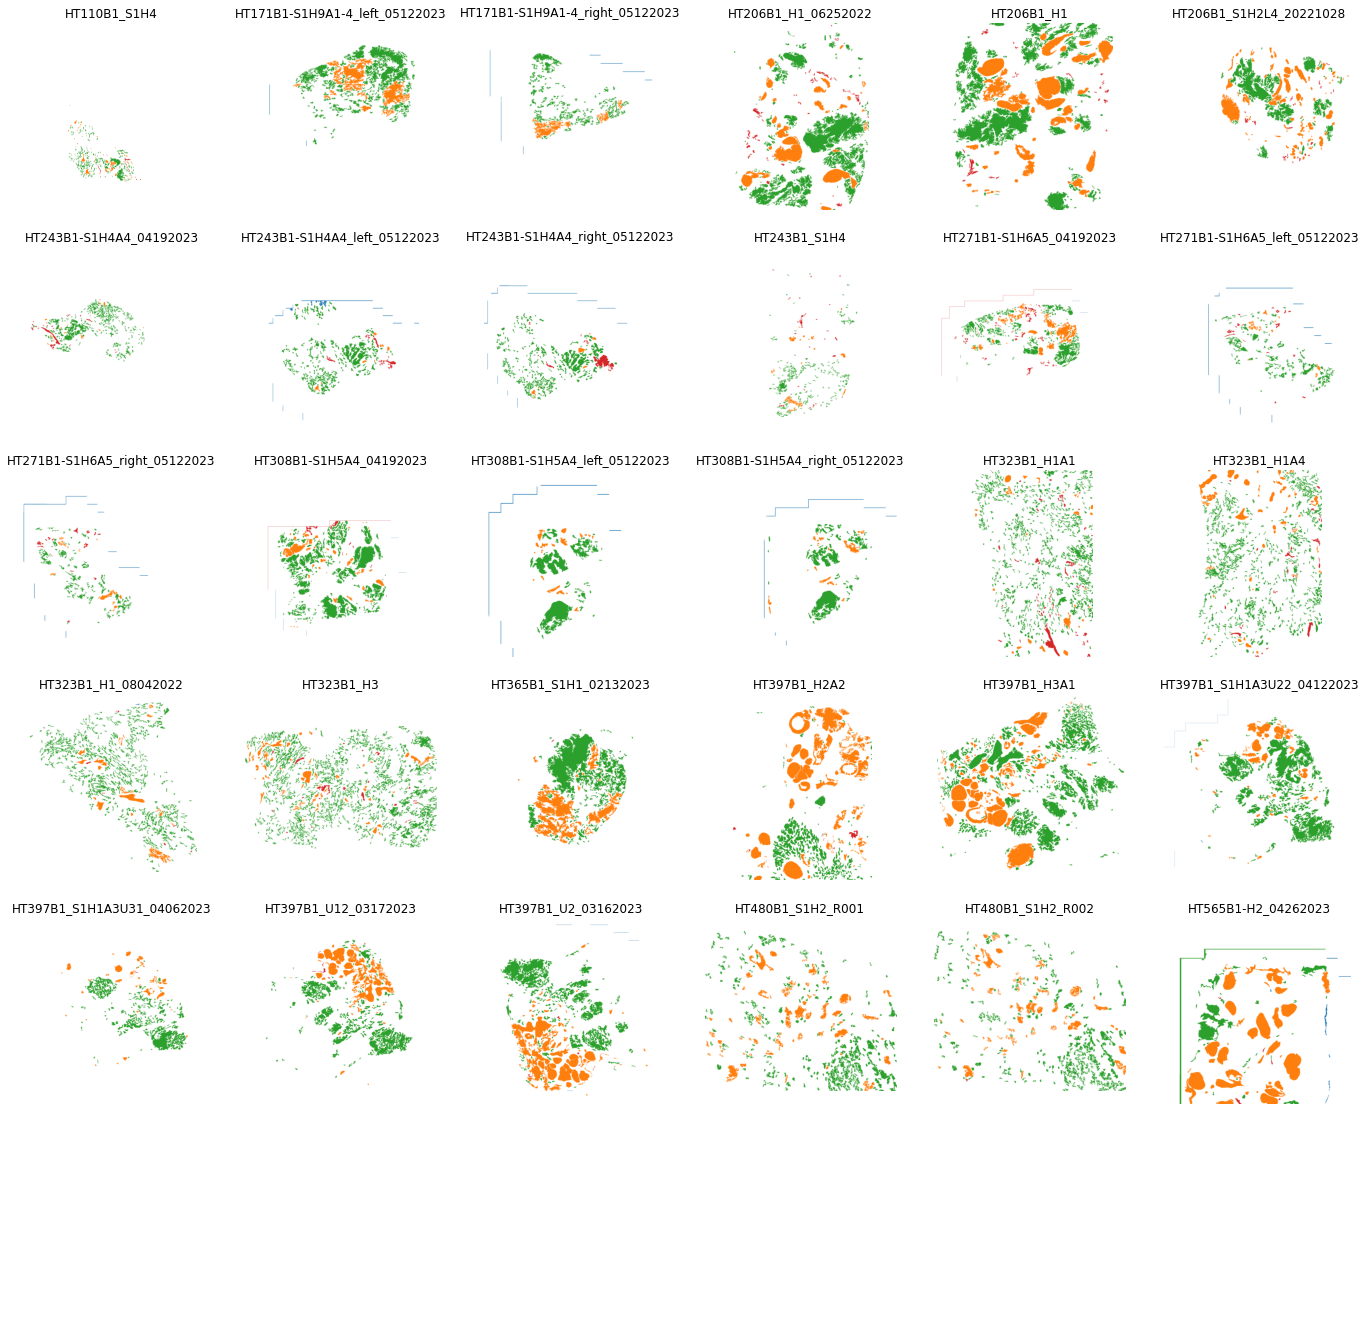

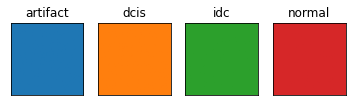

In [144]:
show_regions('region', 'predicted_label')

In [178]:
remove = [
    'HT565B1-H2_04262023_1',
    'HT271B1-S1H6A5_04192023_1',
    'HT308B1-S1H5A4_04192023_1'
]
for k, combined in type_to_combined.items():
    combined = combined[combined['predicted_label']!='artifact']
    combined = combined[[False if x in remove else True for x in combined.index.to_list()]]
    type_to_combined[k] = combined

In [146]:
# df = type_to_combined['region'].copy()
# df['distance'] = df['r2'] - df['r1']
# df.sort_values('distance', ascending=False)

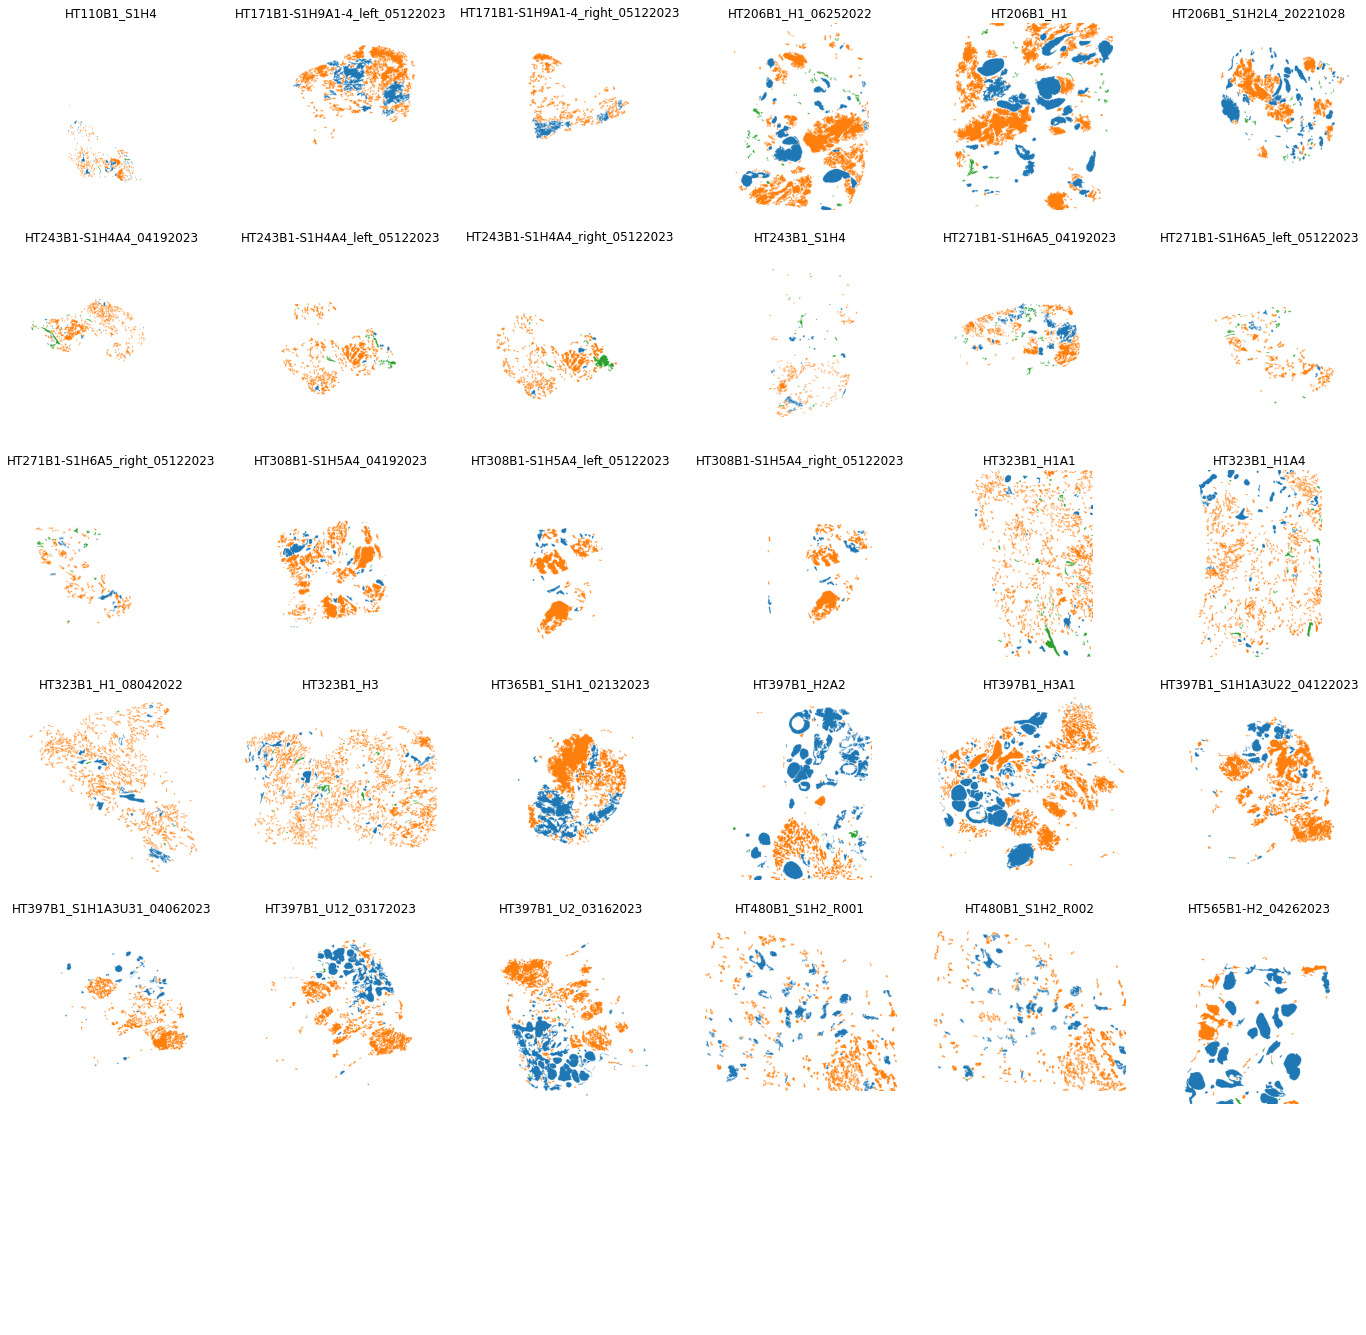

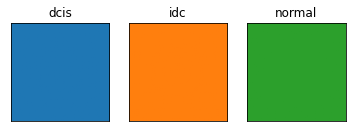

In [147]:
show_regions('region', 'predicted_label')

In [179]:
df = type_to_combined['region'].copy()
df = df[df['sample'] == 'HT206B1_S1H2L4_20221028']
df

area     c1     c2 cell_type_fraction_B cell  \
label                                                                        
HT206B1_S1H2L4_20221028_1    79930  10064  10293                       NaN   
HT206B1_S1H2L4_20221028_2    14626   9295   9397                       0.0   
HT206B1_S1H2L4_20221028_3    91185   8195   8621                       0.0   
HT206B1_S1H2L4_20221028_4    41259   7177   7393                       0.0   
HT206B1_S1H2L4_20221028_5    93462  10463  10773                       NaN   
...                            ...    ...    ...                       ...   
HT206B1_S1H2L4_20221028_187  14147  11769  11909                       0.0   
HT206B1_S1H2L4_20221028_188  15063  12723  12887                       NaN   
HT206B1_S1H2L4_20221028_189  32672  12911  13098                       NaN   
HT206B1_S1H2L4_20221028_190  20375  11429  11642                       NaN   
HT206B1_S1H2L4_20221028_191  10574  12268  12407                       NaN   

                            cell_type_fraction_CD4 T cell  \
label                                                       
HT206B1_S1H2L4_20221028_1                             NaN   
HT206B1_S1H2L4_20221028_2                            0.05   
HT206B1_S1H2L4_20221028_3                             0.0   
HT206B1_S1H2L4_20221028_4                        0.260274   
HT206B1_S1H2L4_20221028_5                             NaN   
...                                                   ...   
HT206B1_S1H2L4_20221028_187                           0.0   
HT206B1_S1H2L4_20221028_188                           NaN   
HT206B1_S1H2L4_20221028_189                           NaN   
HT206B1_S1H2L4_20221028_190                           NaN   
HT206B1_S1H2L4_20221028_191                           NaN   

                            cell_type_fraction_CD8 T cell  \
label                                                       
HT206B1_S1H2L4_20221028_1                             NaN   
HT206B1_S1H2L4_20221028_2                             0.0   
HT206B1_S1H2L4_20221028_3                           0.008   
HT206B1_S1H2L4_20221028_4                             0.0   
HT206B1_S1H2L4_20221028_5                             NaN   
...                                                   ...   
HT206B1_S1H2L4_20221028_187                           0.0   
HT206B1_S1H2L4_20221028_188                           NaN   
HT206B1_S1H2L4_20221028_189                           NaN   
HT206B1_S1H2L4_20221028_190                           NaN   
HT206B1_S1H2L4_20221028_191                           NaN   

                            cell_type_fraction_Endothelial  \
label                                                        
HT206B1_S1H2L4_20221028_1                              NaN   
HT206B1_S1H2L4_20221028_2                             0.05   
HT206B1_S1H2L4_20221028_3                            0.016   
HT206B1_S1H2L4_20221028_4                         0.232877   
HT206B1_S1H2L4_20221028_5                              NaN   
...                                                    ...   
HT206B1_S1H2L4_20221028_187                            0.0   
HT206B1_S1H2L4_20221028_188                            NaN   
HT206B1_S1H2L4_20221028_189                            NaN   
HT206B1_S1H2L4_20221028_190                            NaN   
HT206B1_S1H2L4_20221028_191                            NaN   

                            cell_type_fraction_Epithelial  \
label                                                       
HT206B1_S1H2L4_20221028_1                             NaN   
HT206B1_S1H2L4_20221028_2                             0.0   
HT206B1_S1H2L4_20221028_3                           0.504   
HT206B1_S1H2L4_20221028_4                             0.0   
HT206B1_S1H2L4_20221028_5                             NaN   
...                                                   ...   
HT206B1_S1H2L4_20221028_187                           0.0   
HT206B1_S1H2L4_20221028_188                           NaN   
HT206B1_S1

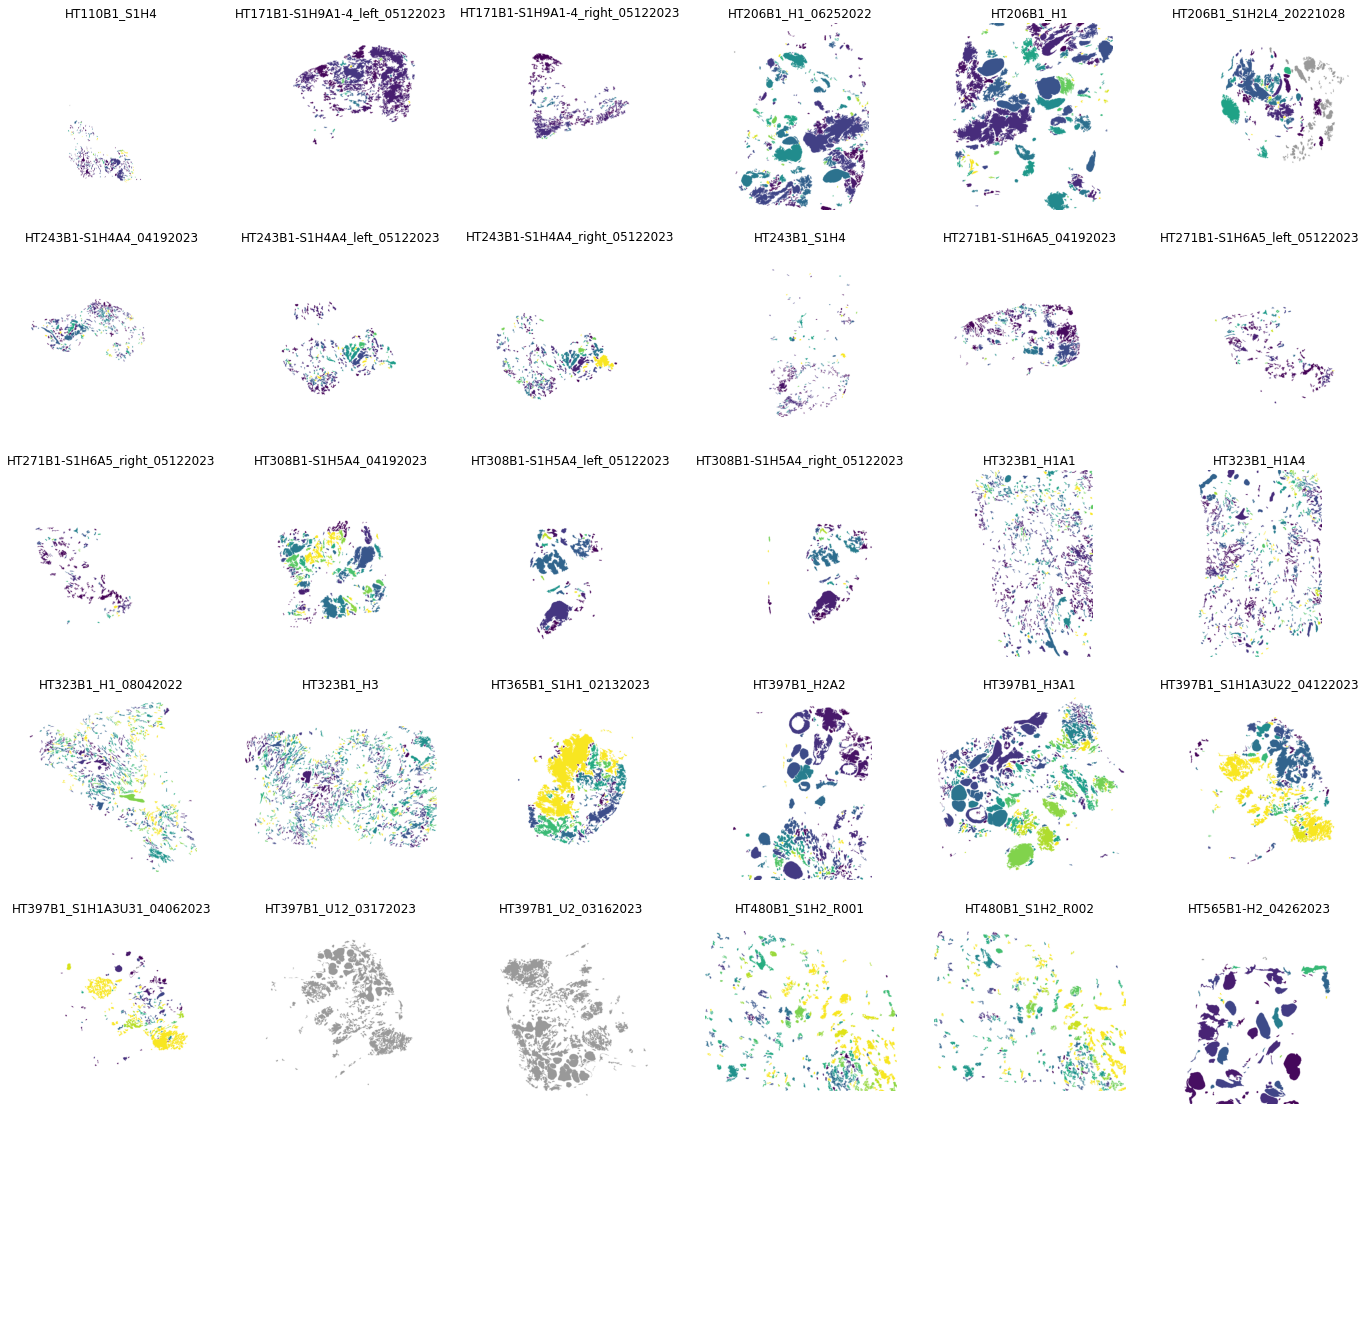

In [149]:
show_regions('boundary', 'cell_type_fraction_CD8 T cell', vmax=.1)

In [183]:
df = type_to_combined['region'].copy()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'HT110B1_S1H4'),
  Text(1, 0, 'HT171B1-S1H9A1-4_left_05122023'),
  Text(2, 0, 'HT171B1-S1H9A1-4_right_05122023'),
  Text(3, 0, 'HT206B1_H1_06252022'),
  Text(4, 0, 'HT206B1_H1'),
  Text(5, 0, 'HT206B1_S1H2L4_20221028'),
  Text(6, 0, 'HT243B1-S1H4A4_04192023'),
  Text(7, 0, 'HT243B1-S1H4A4_left_05122023'),
  Text(8, 0, 'HT243B1-S1H4A4_right_05122023'),
  Text(9, 0, 'HT243B1_S1H4'),
  Text(10, 0, 'HT271B1-S1H6A5_04192023'),
  Text(11, 0, 'HT271B1-S1H6A5_left_05122023'),
  Text(12, 0, 'HT271B1-S1H6A5_right_05122023'),
  Text(13, 0, 'HT308B1-S1H5A4_04192023'),
  Text(14, 0, 'HT308B1-S1H5A4_left_05122023'),
  Text(15, 0, 'HT308B1-S1H5A4_right_05122023'),
  Text(16, 0, 'HT323B1_H1A1'),
  Text(17, 0, 'HT323B1_H1A4'),
  Text(18, 0, 'HT323B1_H1_08042022'),
  Text(19, 0, 'HT323B1_H3'),
  Text(20, 0, 'HT365B1_S1H1_02132023'),
  Text(21, 0, 'HT397B1

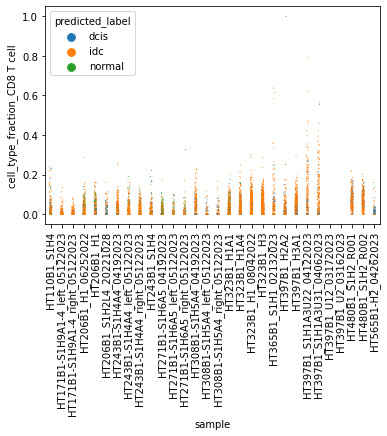

In [159]:
sns.stripplot(data=df, x='sample', y='cell_type_fraction_CD8 T cell', hue='predicted_label', size=1.)
plt.xticks(rotation=90)

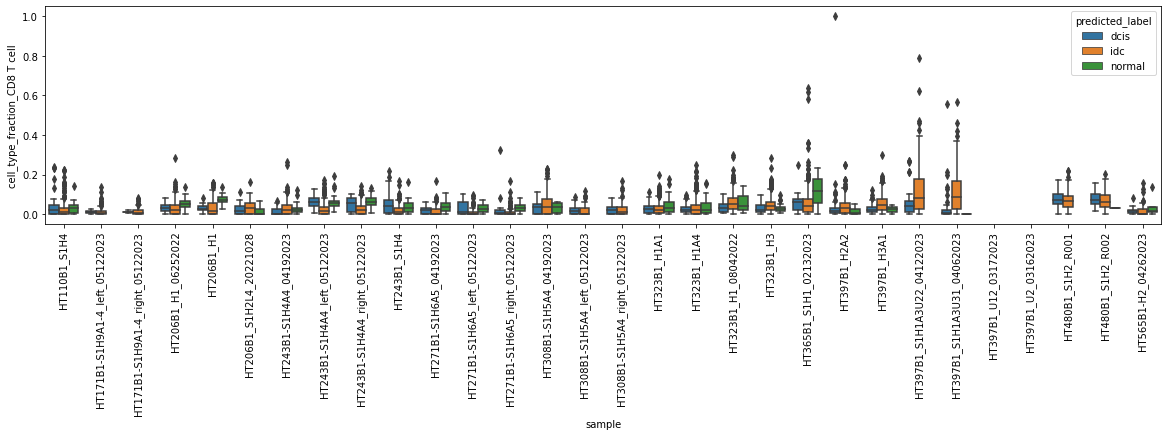

In [163]:
fig, axs = plt.subplots(figsize=(20, 4))
sns.boxplot(data=df, x='sample', y='cell_type_fraction_CD8 T cell', hue='predicted_label')
_ = plt.xticks(rotation=90)

<AxesSubplot:xlabel='predicted_label', ylabel='cell_type_fraction_CD8 T cell'>

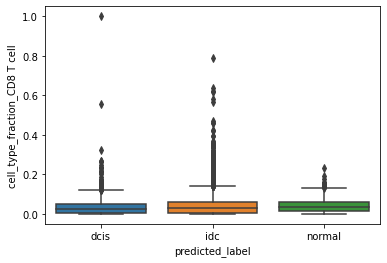

In [164]:
sns.boxplot(data=df, x='predicted_label', y='cell_type_fraction_CD8 T cell')


In [180]:
key = 'marker_intensity_MGP'

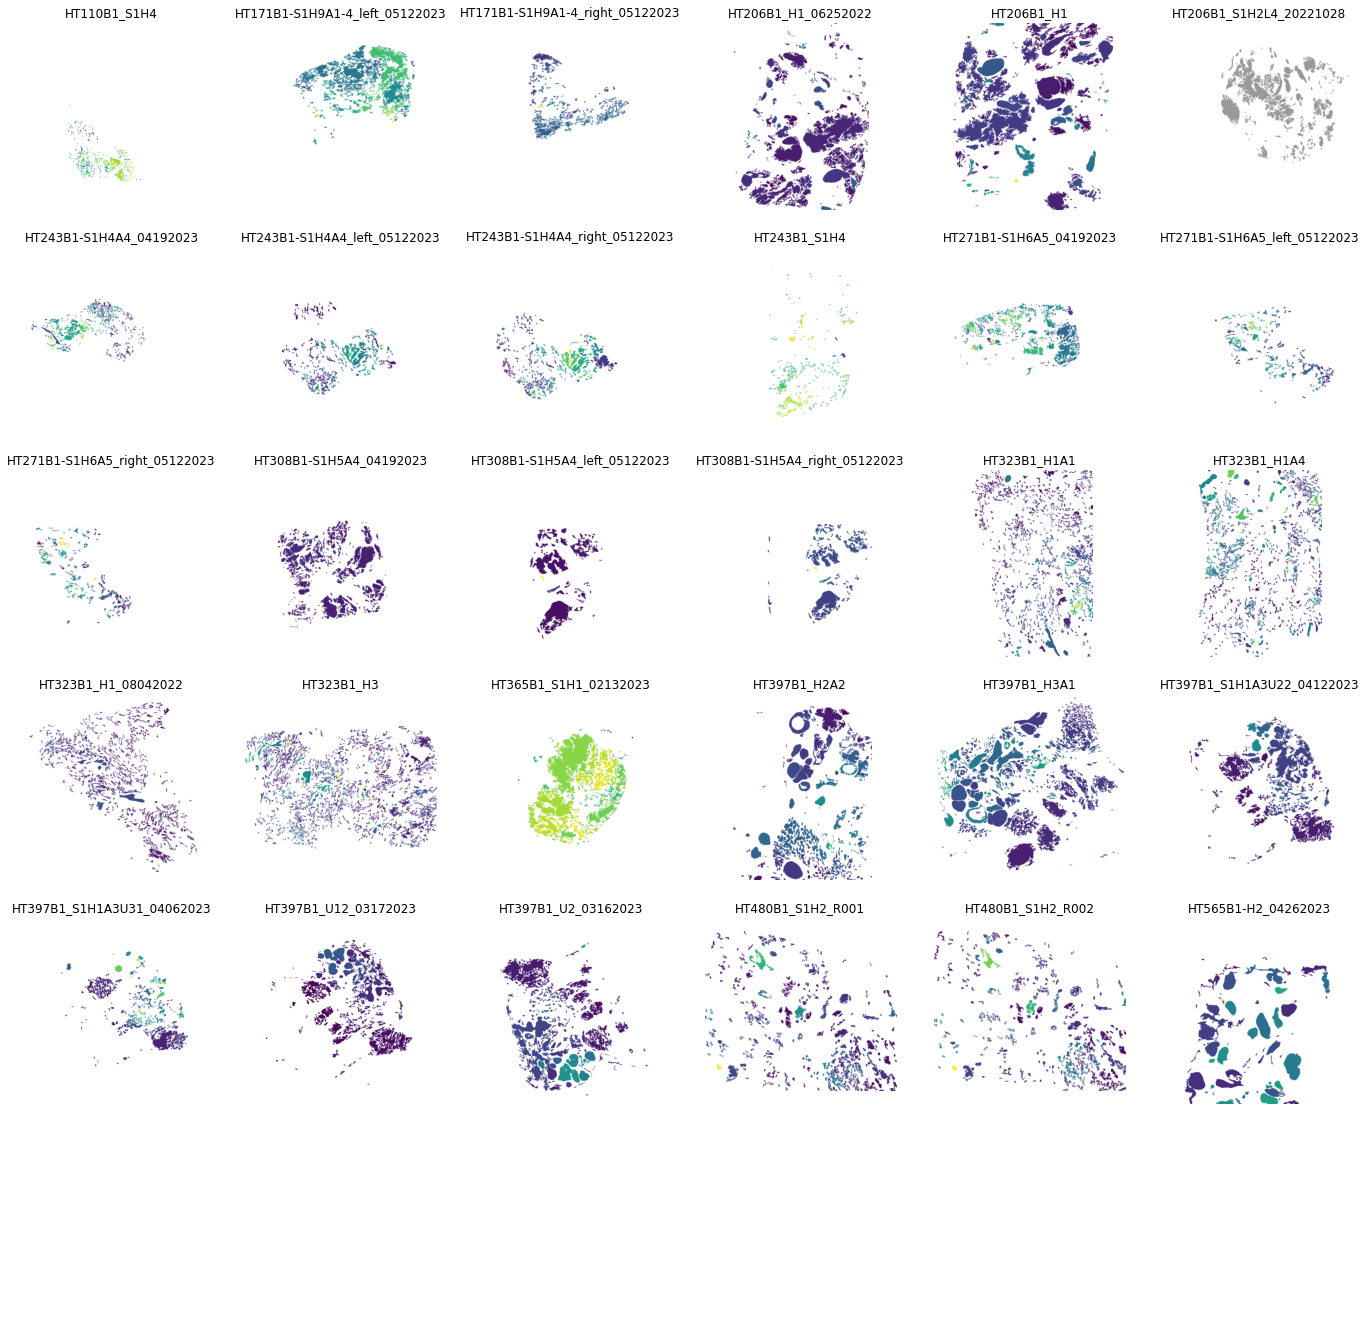

In [181]:
show_regions('region', key)

In [189]:
from scipy.stats import ttest_ind

<AxesSubplot:xlabel='predicted_label', ylabel='marker_intensity_MGP'>

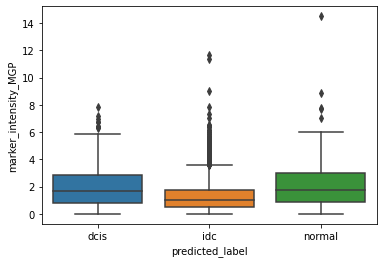

In [184]:
sns.boxplot(data=df, x='predicted_label', y=key)


In [192]:
xs = np.asarray([x for x in df[df['predicted_label']=='normal'][key] if not pd.isnull(x)])
ys = np.asarray([x for x in df[df['predicted_label']=='idc'][key] if not pd.isnull(x)])

ttest_ind(xs, ys)

Ttest_indResult(statistic=13.25368412392739, pvalue=1.12277272677762e-39)

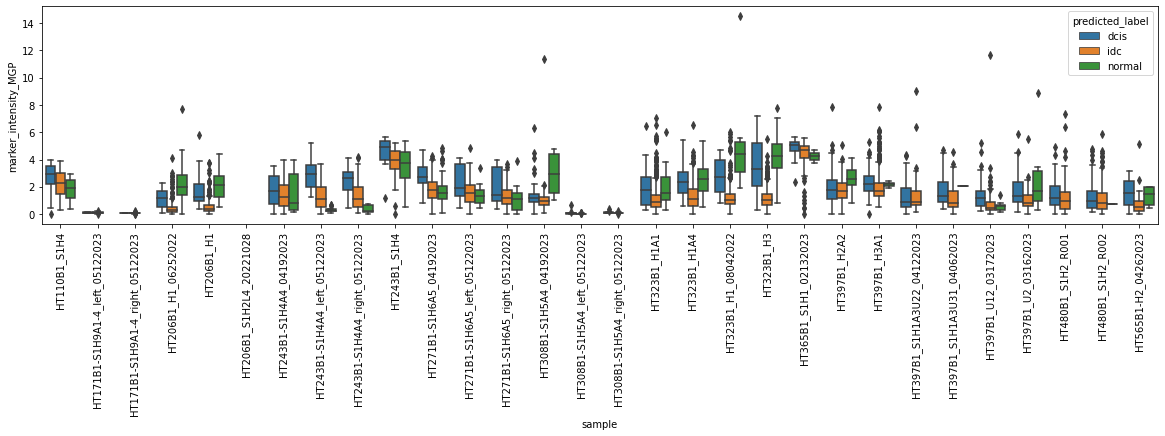

In [188]:
fig, axs = plt.subplots(figsize=(20, 4))
sns.boxplot(data=df, x='sample', y=key, hue='predicted_label')
_ = plt.xticks(rotation=90)

<AxesSubplot:xlabel='predicted_label', ylabel='marker_intensity_MGP'>

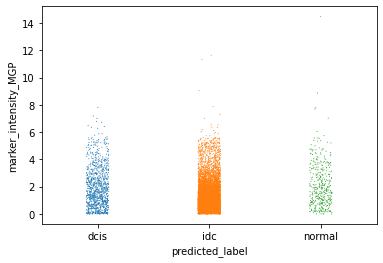

In [186]:
sns.stripplot(data=df, x='predicted_label', y=key, size=1.)


<AxesSubplot:xlabel='sample', ylabel='marker_intensity_MGP'>

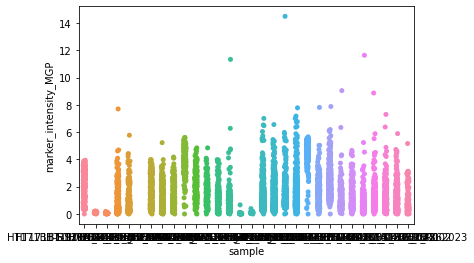

In [187]:
sns.stripplot(data=df, x='sample', y=key)


In [202]:
keys = [
    'cell_type_fraction_B cell',
    'cell_type_fraction_CD4 T cell',
    'cell_type_fraction_CD8 T cell',
    'cell_type_fraction_Endothelial',
    'cell_type_fraction_Epithelial',
    'cell_type_fraction_Immune',
    'cell_type_fraction_Macrophage - M1',
    'cell_type_fraction_Stroma',
    'cell_type_fraction_Treg',
    'cell_type_fraction_Unlabeled',
    'compactness',
    'marker_fraction_CD11b',
    'marker_fraction_CD163',
    'marker_fraction_CD20',
    'marker_fraction_CD31',
    'marker_fraction_CD3e',
    'marker_fraction_CD4',
    'marker_fraction_CD45',
    'marker_fraction_CD68',
    'marker_fraction_CD8',
    'marker_fraction_CK14',
    'marker_fraction_CK17',
    'marker_fraction_CK5',
    'marker_fraction_E-cadherin',
    'marker_fraction_FOXP3',
    'marker_fraction_Ki67',
    'marker_fraction_Pan-Cytokeratin',
    'marker_fraction_Podoplanin',
    'marker_fraction_SMA',
    'marker_intensity_BCA1',
    'marker_intensity_Bap1',
    'marker_intensity_CD11b',
    'marker_intensity_CD11c',
    'marker_intensity_CD138',
    'marker_intensity_CD163',
    'marker_intensity_CD20',
    'marker_intensity_CD31',
    'marker_intensity_CD36',
    'marker_intensity_CD3e',
    'marker_intensity_CD4',
    'marker_intensity_CD44',
    'marker_intensity_CD45',
    'marker_intensity_CD45RA',
    'marker_intensity_CD68',
    'marker_intensity_CD8',
    'marker_intensity_CK14',
    'marker_intensity_CK17',
    'marker_intensity_CK19',
    'marker_intensity_CK5',
    'marker_intensity_COX2',
    'marker_intensity_COX6c',
    'marker_intensity_CTLA4',
    'marker_intensity_DAPI',
    'marker_intensity_E-cadherin',
    'marker_intensity_ER',
    'marker_intensity_FGFR3',
    'marker_intensity_FOXP3',
    'marker_intensity_GATA3',
    'marker_intensity_GATA3 (D)',
    'marker_intensity_GLUT1',
    'marker_intensity_GLUT1 (D)',
    'marker_intensity_HIF1a',
    'marker_intensity_HLA-DR',
    'marker_intensity_Hep-Par-1 (D)',
    'marker_intensity_Her2',
    'marker_intensity_Histone H3 Pho',
    'marker_intensity_Histone H3 Phospho (Ser28)',
    'marker_intensity_Ki67',
    'marker_intensity_Lyve-1',
    'marker_intensity_MGP',
    'marker_intensity_MLPH',
    'marker_intensity_MMP9',
    'marker_intensity_Maspin',
    'marker_intensity_P16',
    'marker_intensity_P21',
    'marker_intensity_PD-1',
    'marker_intensity_PD-L1',
    'marker_intensity_PLAT/tPA',
    'marker_intensity_PR',
    'marker_intensity_PR (D)',
    'marker_intensity_Pan-Cytokeratin',
    'marker_intensity_Podoplanin',
    'marker_intensity_SLC39A6',
    'marker_intensity_SMA',
    'marker_intensity_TFF1',
    'marker_intensity_TFF1 (D)',
    'marker_intensity_Vimentin',
    'marker_intensity_a-Amylase',
    'marker_intensity_beta-integrin',
    'marker_intensity_cKit',
    'perimeter',
]
tups = []
for key in keys:
    df = type_to_combined['region']
    f = df[df['predicted_label']=='dcis']
    xs = [np.mean([x for x in f[f['sample']==sample][key] if not pd.isnull(x)])
             for sample in sorted(set(f['sample']))]
    f = df[df['predicted_label']=='idc']
    ys = [np.mean([x for x in f[f['sample']==sample][key] if not pd.isnull(x)])
             for sample in sorted(set(f['sample']))]
    
    xs, ys = [x for x in xs if not pd.isnull(x)], [x for x in ys if not pd.isnull(x)]
#     print(xs, ys)
#     xs = np.asarray([x for x in df[df['predicted_label']=='dcis'][key] if not pd.isnull(x)])
#     ys = np.asarray([x for x in df[df['predicted_label']=='idc'][key] if not pd.isnull(x)])

    val = ttest_ind(xs, ys).pvalue
    tups.append((key, val))
sorted(tups, key=lambda x:x[-1])

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[('marker_fraction_Podoplanin', 0.00032068780838077535),
 ('marker_fraction_CK14', 0.006321988001019368),
 ('marker_intensity_CK14', 0.02192980583923702),
 ('marker_intensity_CD44', 0.06570563503823383),
 ('compactness', 0.13387672594669042),
 ('marker_fraction_Pan-Cytokeratin', 0.1520791976677353),
 ('marker_fraction_SMA', 0.1676454095426419),
 ('marker_fraction_CD163', 0.21662050548820974),
 ('marker_fraction_CD31', 0.22945145212264834),
 ('marker_fraction_CD45', 0.23306821416572182),
 ('marker_fraction_E-cadherin', 0.27456605173599075),
 ('marker_fraction_CD8', 0.31705275963122204),
 ('marker_intensity_BCA1', 0.45603641267604833),
 ('marker_intensity_CD138', 0.4710938208803266),
 ('marker_intensity_CD4', 0.5116334442246488),
 ('marker_fraction_FOXP3', 0.520133741381001),
 ('marker_intensity_CD68', 0.5231338068776376),
 ('cell_type_fraction_Unlabeled', 0.5641594154610471),
 ('marker_intensity_CD45RA', 0.5654273279856337),
 ('cell_type_fraction_B cell', 0.5671546290445061),
 ('marker_

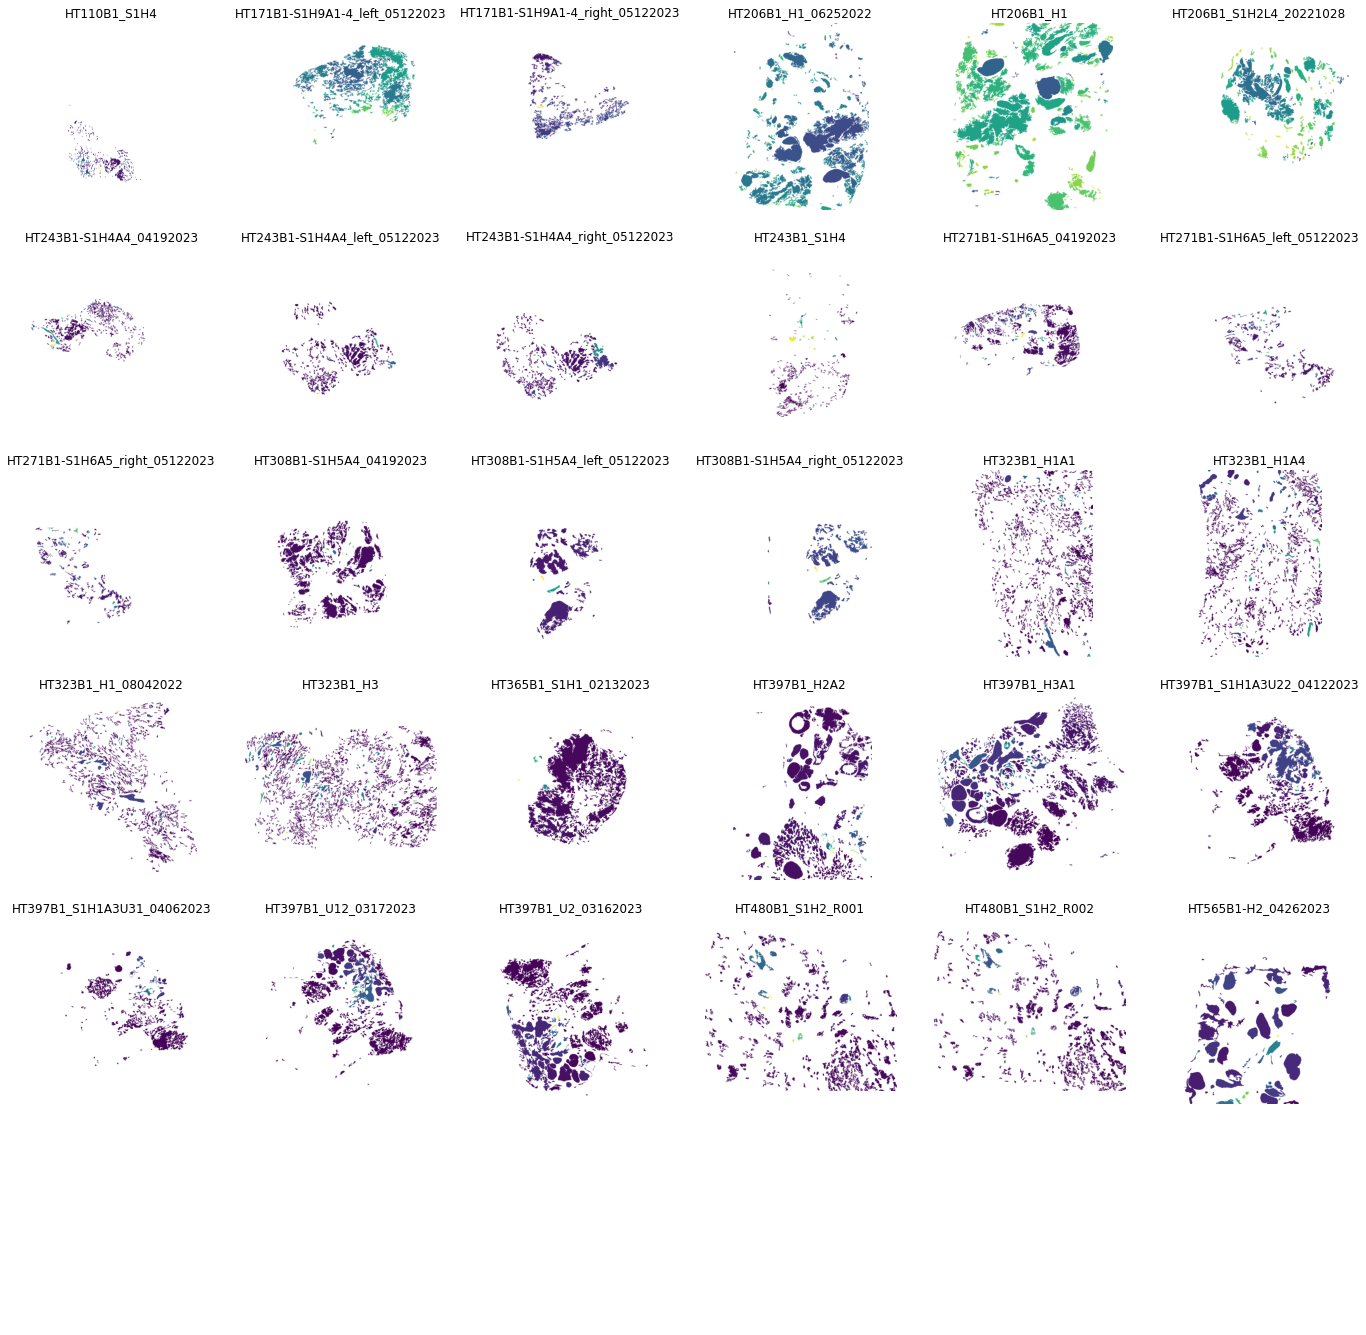

In [205]:
show_regions('region', 'marker_intensity_CK14')

<AxesSubplot:xlabel='predicted_label', ylabel='marker_intensity_CK14'>

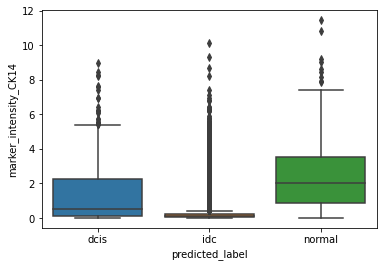

In [208]:
df = type_to_combined['region']
sns.boxplot(data=df, x='predicted_label', y='marker_intensity_CK14')


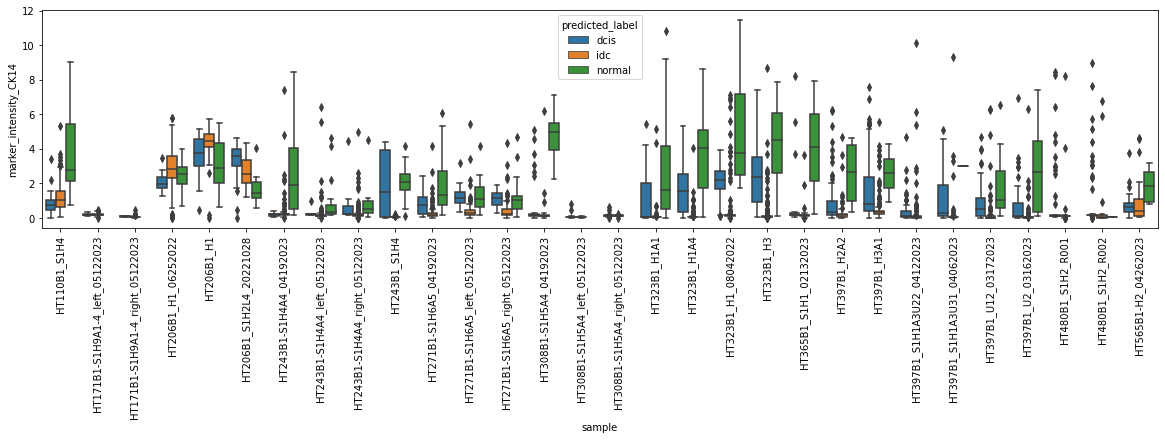

In [207]:
df = type_to_combined['region']
fig, axs = plt.subplots(figsize=(20, 4))
sns.boxplot(data=df, x='sample', y='marker_intensity_CK14', hue='predicted_label')
_ = plt.xticks(rotation=90)

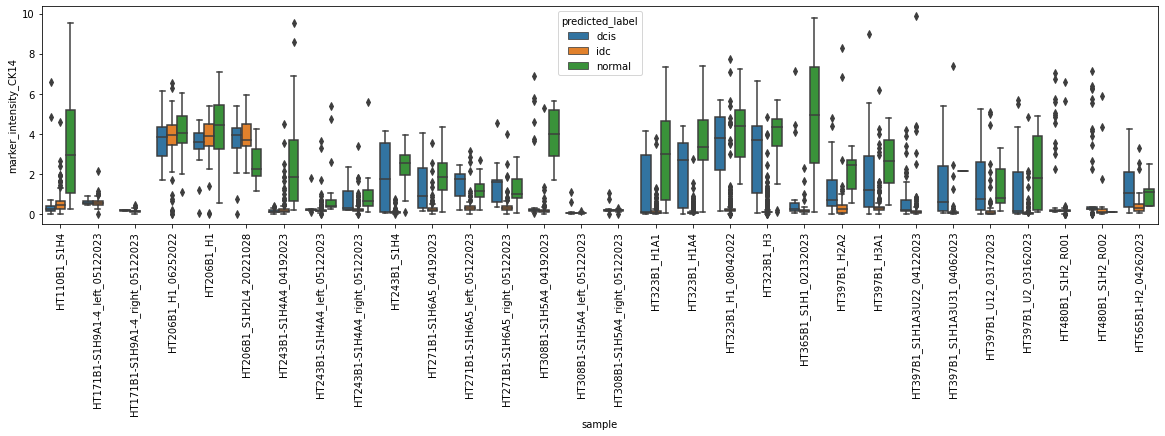

In [209]:
df = type_to_combined['myoepi']
fig, axs = plt.subplots(figsize=(20, 4))
sns.boxplot(data=df, x='sample', y='marker_intensity_CK14', hue='predicted_label')
_ = plt.xticks(rotation=90)

<AxesSubplot:xlabel='predicted_label', ylabel='marker_intensity_CK14'>

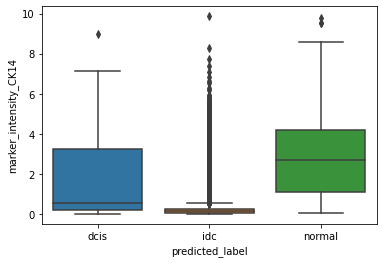

In [210]:
df = type_to_combined['myoepi']
sns.boxplot(data=df, x='predicted_label', y='marker_intensity_CK14')


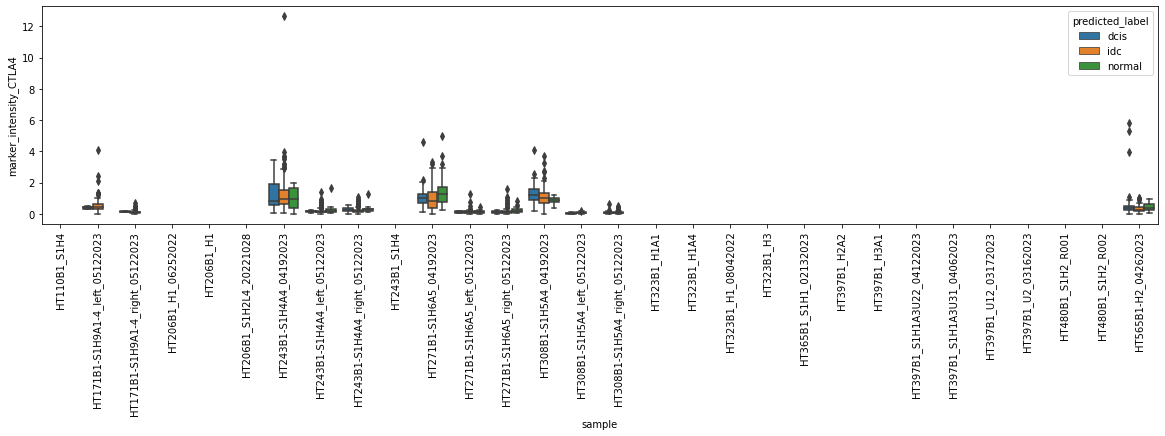

In [240]:
df = type_to_combined['boundary']
fig, axs = plt.subplots(figsize=(20, 4))
sns.boxplot(data=df, x='sample', y='marker_intensity_CTLA4', hue='predicted_label')
_ = plt.xticks(rotation=90)

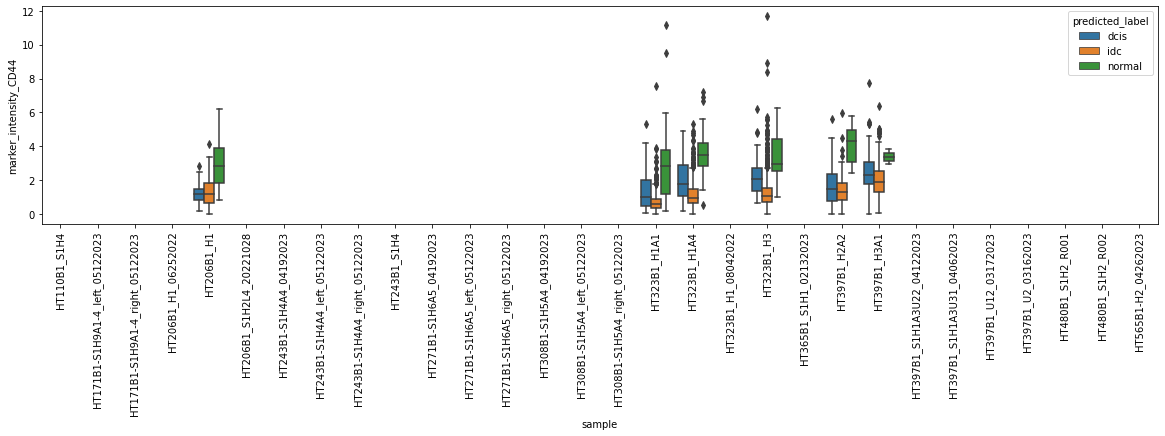

In [211]:
df = type_to_combined['region']
fig, axs = plt.subplots(figsize=(20, 4))
sns.boxplot(data=df, x='sample', y='marker_intensity_CD44', hue='predicted_label')
_ = plt.xticks(rotation=90)

In [212]:
keys = [
    'cell_type_fraction_B cell',
    'cell_type_fraction_CD4 T cell',
    'cell_type_fraction_CD8 T cell',
    'cell_type_fraction_Endothelial',
    'cell_type_fraction_Epithelial',
    'cell_type_fraction_Immune',
    'cell_type_fraction_Macrophage - M1',
    'cell_type_fraction_Stroma',
    'cell_type_fraction_Treg',
    'cell_type_fraction_Unlabeled',
    'compactness',
    'marker_fraction_CD11b',
    'marker_fraction_CD163',
    'marker_fraction_CD20',
    'marker_fraction_CD31',
    'marker_fraction_CD3e',
    'marker_fraction_CD4',
    'marker_fraction_CD45',
    'marker_fraction_CD68',
    'marker_fraction_CD8',
    'marker_fraction_CK14',
    'marker_fraction_CK17',
    'marker_fraction_CK5',
    'marker_fraction_E-cadherin',
    'marker_fraction_FOXP3',
    'marker_fraction_Ki67',
    'marker_fraction_Pan-Cytokeratin',
    'marker_fraction_Podoplanin',
    'marker_fraction_SMA',
    'marker_intensity_BCA1',
    'marker_intensity_Bap1',
    'marker_intensity_CD11b',
    'marker_intensity_CD11c',
    'marker_intensity_CD138',
    'marker_intensity_CD163',
    'marker_intensity_CD20',
    'marker_intensity_CD31',
    'marker_intensity_CD36',
    'marker_intensity_CD3e',
    'marker_intensity_CD4',
    'marker_intensity_CD44',
    'marker_intensity_CD45',
    'marker_intensity_CD45RA',
    'marker_intensity_CD68',
    'marker_intensity_CD8',
    'marker_intensity_CK14',
    'marker_intensity_CK17',
    'marker_intensity_CK19',
    'marker_intensity_CK5',
    'marker_intensity_COX2',
    'marker_intensity_COX6c',
    'marker_intensity_CTLA4',
    'marker_intensity_DAPI',
    'marker_intensity_E-cadherin',
    'marker_intensity_ER',
    'marker_intensity_FGFR3',
    'marker_intensity_FOXP3',
    'marker_intensity_GATA3',
    'marker_intensity_GATA3 (D)',
    'marker_intensity_GLUT1',
    'marker_intensity_GLUT1 (D)',
    'marker_intensity_HIF1a',
    'marker_intensity_HLA-DR',
    'marker_intensity_Hep-Par-1 (D)',
    'marker_intensity_Her2',
    'marker_intensity_Histone H3 Pho',
    'marker_intensity_Histone H3 Phospho (Ser28)',
    'marker_intensity_Ki67',
    'marker_intensity_Lyve-1',
    'marker_intensity_MGP',
    'marker_intensity_MLPH',
    'marker_intensity_MMP9',
    'marker_intensity_Maspin',
    'marker_intensity_P16',
    'marker_intensity_P21',
    'marker_intensity_PD-1',
    'marker_intensity_PD-L1',
    'marker_intensity_PLAT/tPA',
    'marker_intensity_PR',
    'marker_intensity_PR (D)',
    'marker_intensity_Pan-Cytokeratin',
    'marker_intensity_Podoplanin',
    'marker_intensity_SLC39A6',
    'marker_intensity_SMA',
    'marker_intensity_TFF1',
    'marker_intensity_TFF1 (D)',
    'marker_intensity_Vimentin',
    'marker_intensity_a-Amylase',
    'marker_intensity_beta-integrin',
    'marker_intensity_cKit',
    'perimeter',
]
tups = []
for key in keys:
    df = type_to_combined['boundary']
    f = df[df['predicted_label']=='dcis']
    xs = [np.mean([x for x in f[f['sample']==sample][key] if not pd.isnull(x)])
             for sample in sorted(set(f['sample']))]
    f = df[df['predicted_label']=='idc']
    ys = [np.mean([x for x in f[f['sample']==sample][key] if not pd.isnull(x)])
             for sample in sorted(set(f['sample']))]
    
    xs, ys = [x for x in xs if not pd.isnull(x)], [x for x in ys if not pd.isnull(x)]
#     print(xs, ys)
#     xs = np.asarray([x for x in df[df['predicted_label']=='dcis'][key] if not pd.isnull(x)])
#     ys = np.asarray([x for x in df[df['predicted_label']=='idc'][key] if not pd.isnull(x)])

    val = ttest_ind(xs, ys).pvalue
    tups.append((key, val))
sorted(tups, key=lambda x:x[-1])

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[('marker_fraction_Pan-Cytokeratin', 4.40687556720142e-07),
 ('marker_intensity_CK14', 0.0037160885572459184),
 ('cell_type_fraction_Epithelial', 0.0039922334995664355),
 ('marker_fraction_Ki67', 0.017198145197726975),
 ('marker_fraction_CD45', 0.03313233009829233),
 ('marker_fraction_CK14', 0.043104945578190945),
 ('marker_intensity_CD163', 0.06177526894740877),
 ('cell_type_fraction_Unlabeled', 0.17824454298265904),
 ('compactness', 0.20629116642593115),
 ('marker_fraction_CD20', 0.3086717951529837),
 ('cell_type_fraction_Treg', 0.3156290262093292),
 ('marker_fraction_CD163', 0.35833732862815004),
 ('cell_type_fraction_B cell', 0.37363511094118174),
 ('marker_intensity_CD20', 0.46793336754305304),
 ('marker_intensity_CD45', 0.4963657903799067),
 ('marker_intensity_CD11c', 0.49883342075759574),
 ('cell_type_fraction_Endothelial', 0.5112995138484352),
 ('marker_fraction_Podoplanin', 0.5253168514634661),
 ('marker_fraction_CD3e', 0.5405846621118111),
 ('marker_fraction_SMA', 0.591592971

In [253]:

tups = []
for key in keys:
    df = type_to_combined['boundary']
    f = df[df['predicted_label']=='dcis']
    xs = [np.mean([x for x in f[f['sample']==sample][key] if not pd.isnull(x)])
             for sample in sorted(set(f['sample']))]
    f = df[df['predicted_label']=='idc']
    ys = [np.mean([x for x in f[f['sample']==sample][key] if not pd.isnull(x)])
             for sample in sorted(set(f['sample']))]
    
#     print(len(xs), len(ys))
    
    xs, ys = zip(*[(x, y) for x, y in zip(xs, ys)
                   if not pd.isnull(x) and not pd.isnull(y) and x!=0 and y!=0])
#     print(xs, ys)
    xs, ys = np.asarray(xs), np.asarray(ys)
#     print(xs)
    
    fc = np.mean((xs - ys) / xs)
#     fc = np.log2(fc)
#     print((xs - ys) / xs)
                  
    
    
#     (final - initial) / initial

    val = ttest_ind(xs, ys).pvalue
    tups.append((key, val, fc))
sorted(tups, key=lambda x:x[-1])

[('cell_type_fraction_B cell', 0.34188974450958376, -2.0742145713001916),
 ('marker_fraction_Pan-Cytokeratin',
  4.40687556720142e-07,
  -1.7539304780858878),
 ('marker_intensity_CD138', 0.8189261127040998, -1.3928274035284063),
 ('marker_fraction_CK17', 0.6889406343011231, -1.0763946316661839),
 ('marker_fraction_CD45', 0.03313233009829233, -0.9883419579709266),
 ('cell_type_fraction_Treg', 0.3156290262093292, -0.9728361834392845),
 ('cell_type_fraction_Epithelial', 0.0039922334995664355, -0.8672539497863668),
 ('marker_intensity_CK19', 0.00123986760587944, -0.8285000377660107),
 ('marker_fraction_FOXP3', 0.7663062120281384, -0.7573582888657556),
 ('marker_intensity_Pan-Cytokeratin',
  3.908646643407521e-06,
  -0.7113496049709116),
 ('marker_fraction_CD20', 0.3086717951529837, -0.6753752981334622),
 ('marker_fraction_Ki67', 0.017198145197726975, -0.6178171708586868),
 ('compactness', 0.20629116642593115, -0.5285704277640241),
 ('marker_fraction_CD8', 0.6446392676644268, -0.51046431936

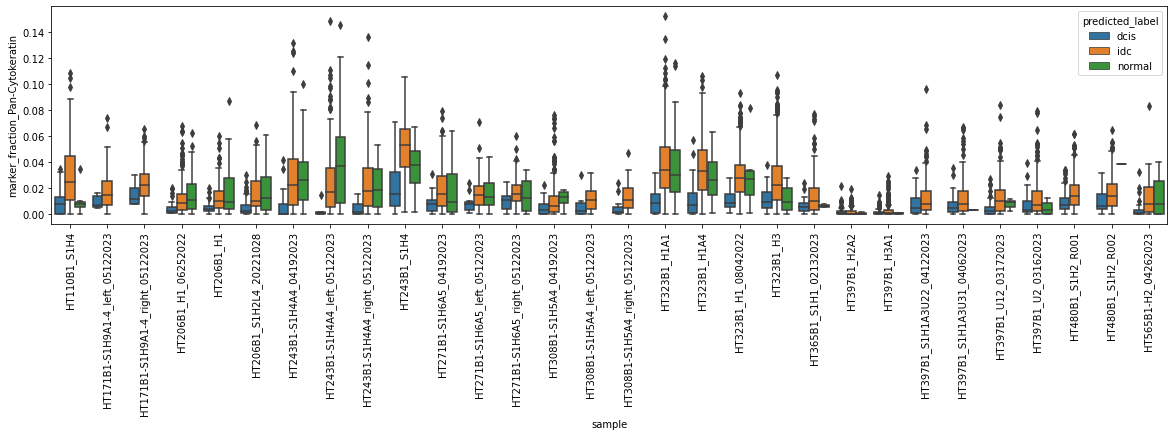

In [255]:
df = type_to_combined['boundary']
fig, axs = plt.subplots(figsize=(20, 4))
sns.boxplot(data=df, x='sample', y='marker_fraction_Pan-Cytokeratin', hue='predicted_label')
_ = plt.xticks(rotation=90)

<AxesSubplot:xlabel='predicted_label', ylabel='marker_intensity_CD45'>

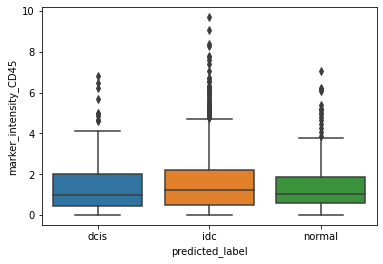

In [214]:
df = type_to_combined['boundary']
sns.boxplot(data=df, x='predicted_label', y='marker_intensity_CD45')


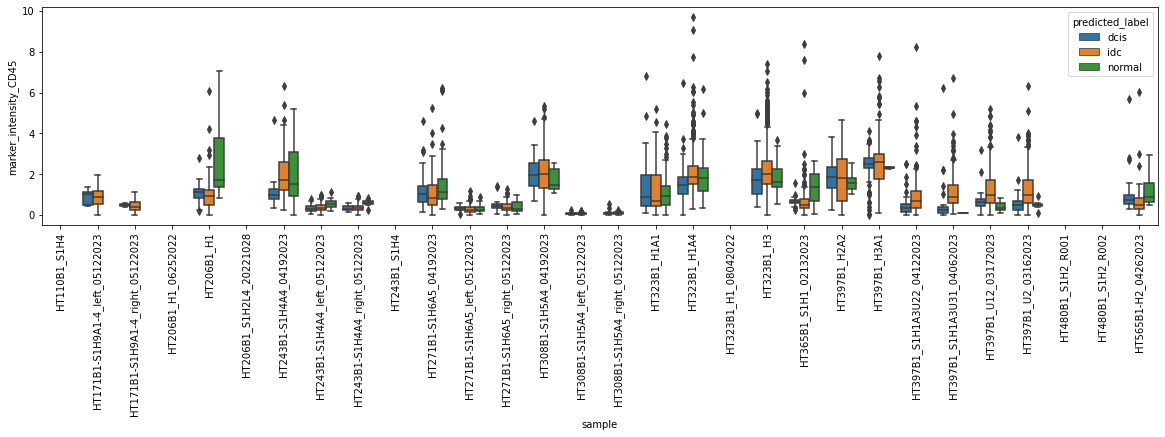

In [213]:
df = type_to_combined['boundary']
fig, axs = plt.subplots(figsize=(20, 4))
sns.boxplot(data=df, x='sample', y='marker_intensity_CD45', hue='predicted_label')
_ = plt.xticks(rotation=90)

<AxesSubplot:xlabel='predicted_label', ylabel='marker_intensity_CD163'>

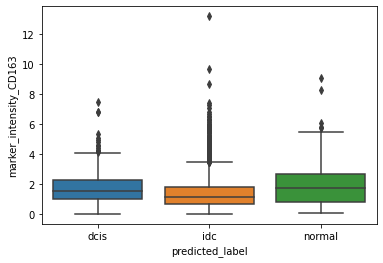

In [215]:
df = type_to_combined['boundary']
sns.boxplot(data=df, x='predicted_label', y='marker_intensity_CD163')


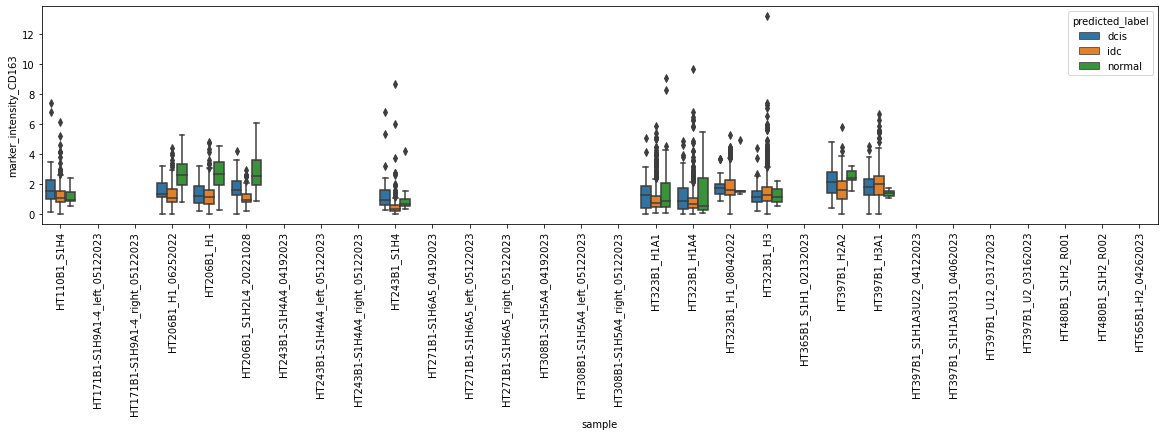

In [216]:
df = type_to_combined['boundary']
fig, axs = plt.subplots(figsize=(20, 4))
sns.boxplot(data=df, x='sample', y='marker_intensity_CD163', hue='predicted_label')
_ = plt.xticks(rotation=90)

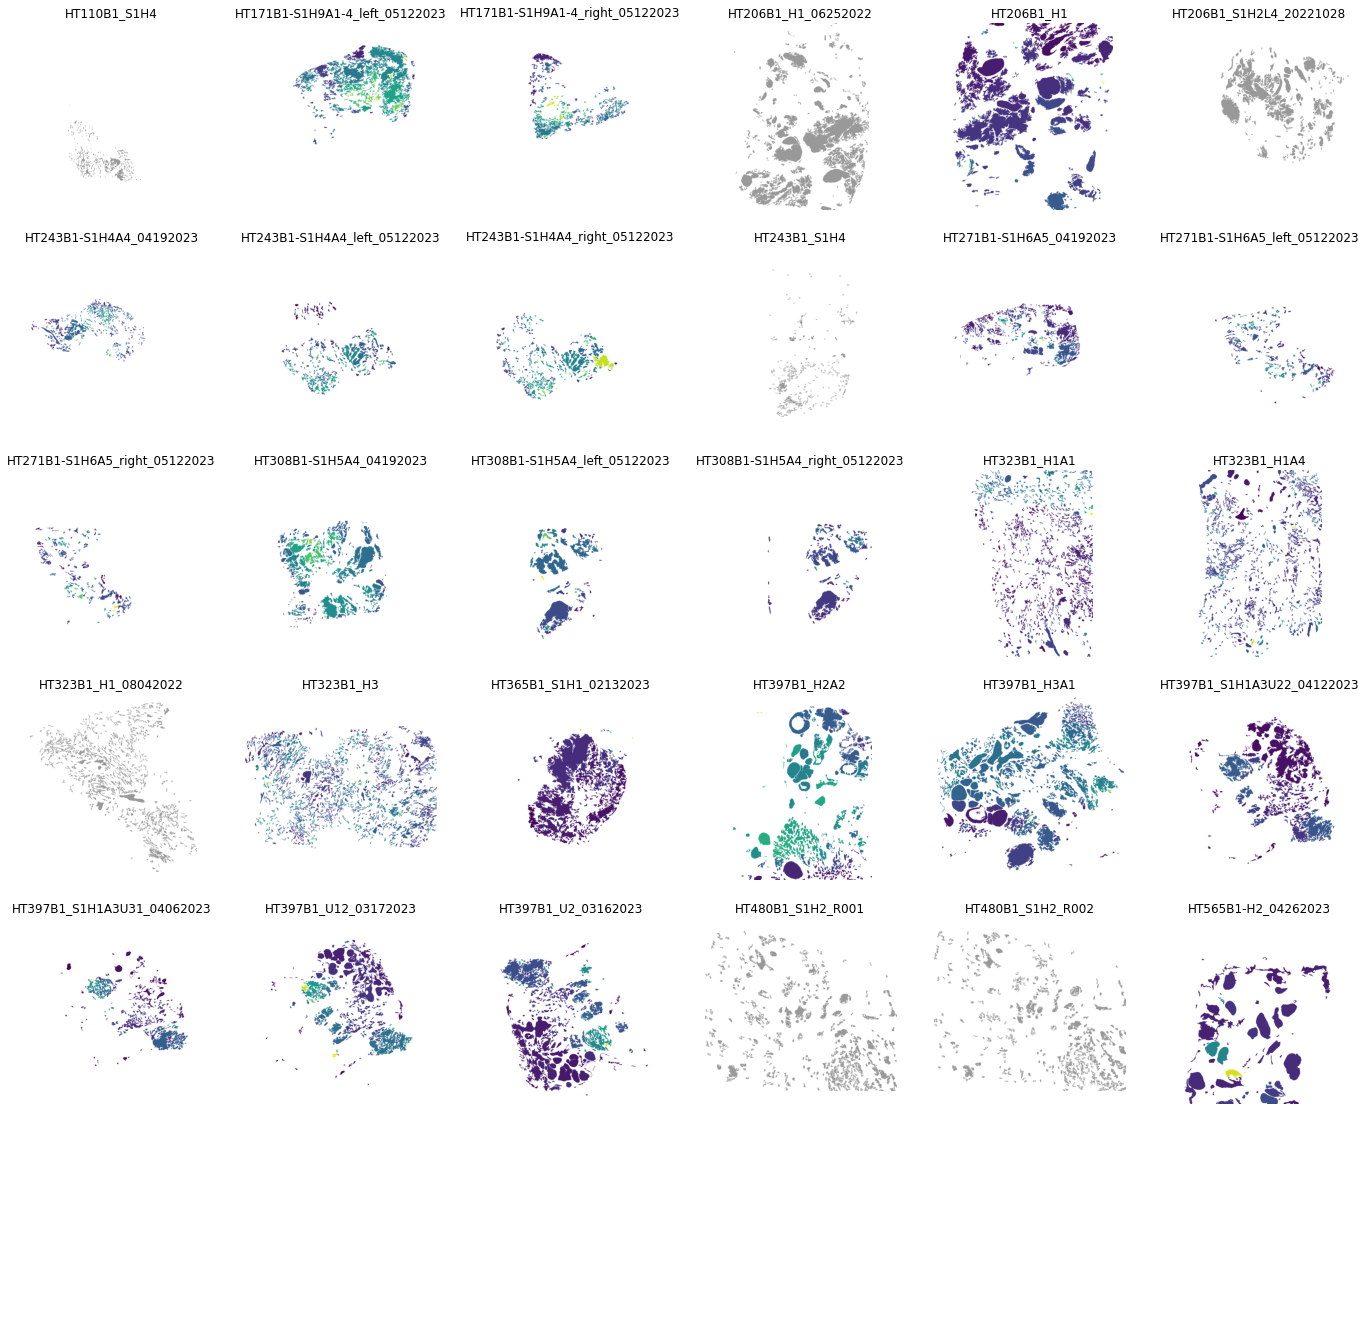

In [217]:
show_regions('boundary', 'marker_intensity_CD45')

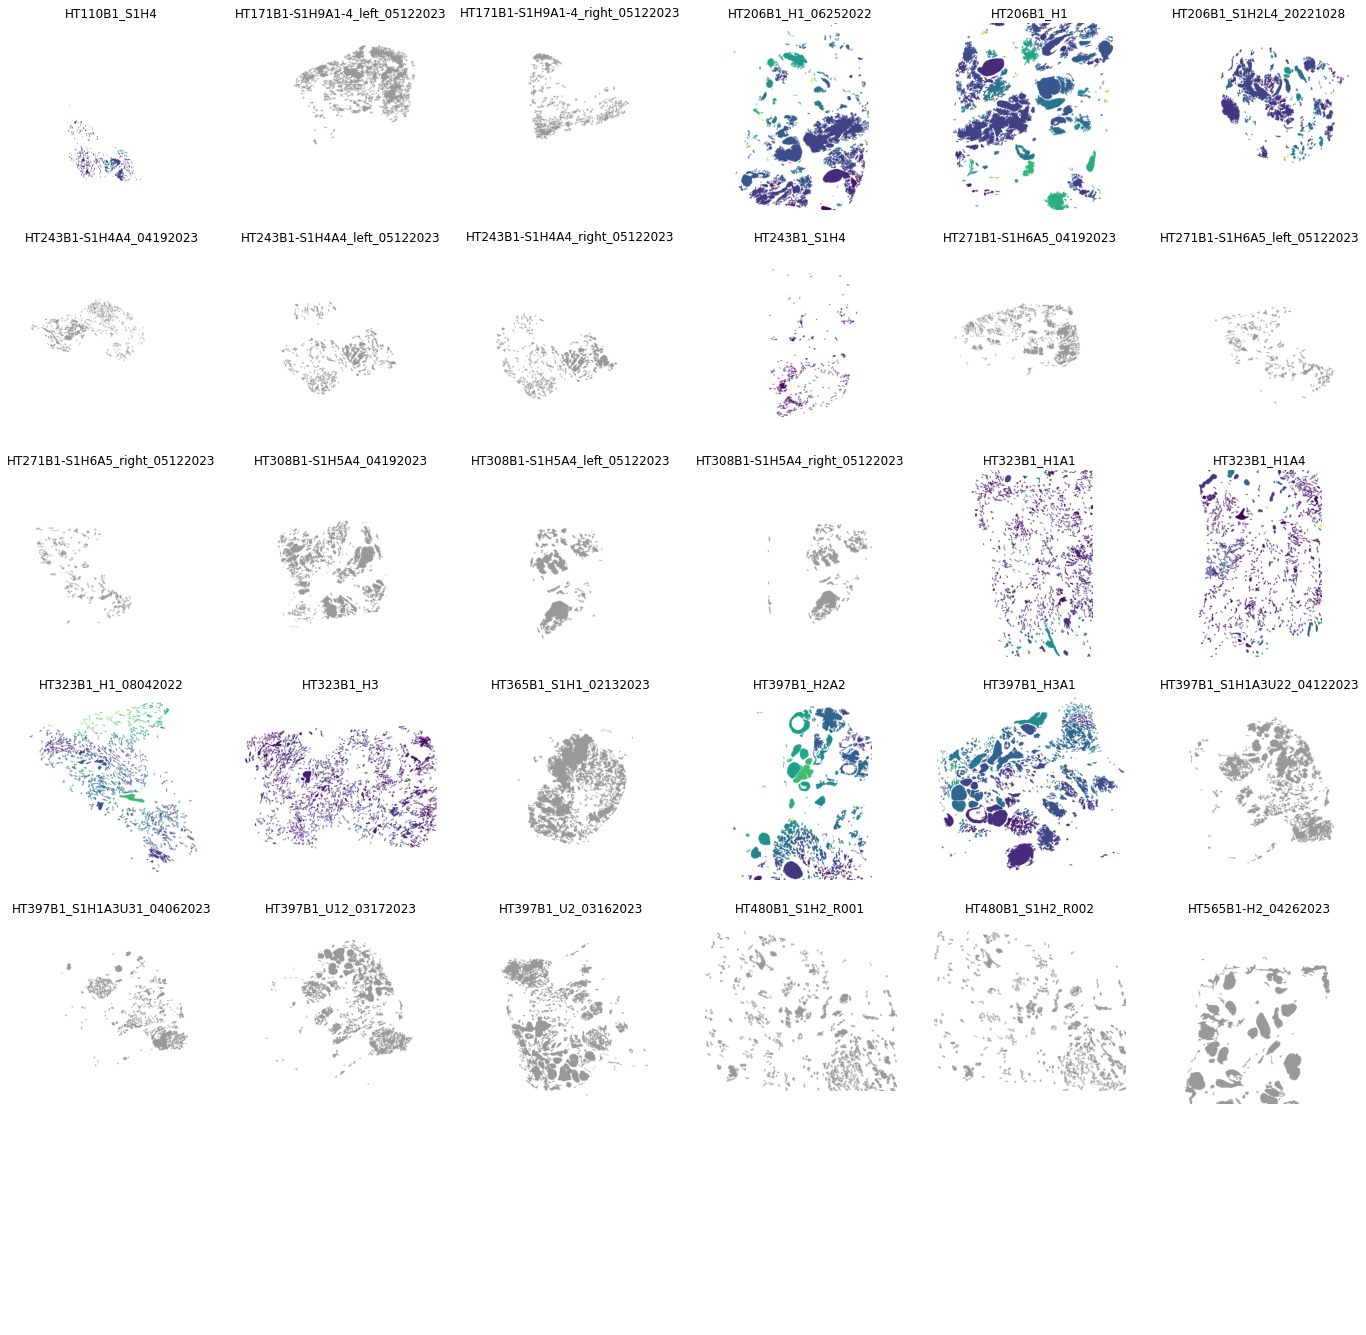

In [218]:
show_regions('boundary', 'marker_intensity_CD163')

In [221]:
## calculate fraction of DCIS vs. IDC in each sample
from collections import Counter
df = type_to_combined['region'].copy()
order = sorted(set(df['predicted_label']))

data = []
for sample in samples:
    f = df[df['sample']==sample]
    counts = Counter(f['predicted_label'])
    row = np.asarray([counts.get(x, 0) for x in order], dtype=float)
    row /= f.shape[0]
    data.append(row)

frac_df = pd.DataFrame(data=data, columns=order, index=samples)
frac_df
    

dcis       idc    normal
HT110B1_S1H4                     0.170290  0.797101  0.032609
HT171B1-S1H9A1-4_left_05122023   0.052326  0.947674  0.000000
HT171B1-S1H9A1-4_right_05122023  0.030675  0.969325  0.000000
HT206B1_H1                       0.138655  0.743697  0.117647
HT206B1_H1_06252022              0.087500  0.734375  0.178125
HT206B1_S1H2L4_20221028          0.439791  0.439791  0.120419
HT243B1-S1H4A4_04192023          0.063091  0.873817  0.063091
HT243B1-S1H4A4_left_05122023     0.030651  0.900383  0.068966
HT243B1-S1H4A4_right_05122023    0.026217  0.936330  0.037453
HT243B1_S1H4                     0.085106  0.812766  0.102128
HT271B1-S1H6A5_04192023          0.124031  0.670543  0.205426
HT271B1-S1H6A5_left_05122023     0.079710  0.782609  0.137681
HT271B1-S1H6A5_right_05122023    0.103175  0.761905  0.134921
HT308B1-S1H5A4_04192023          0.159091  0.818182  0.022727
HT308B1-S1H5A4_left_05122023     0.298507  0.701493  0.000000
HT308B1-S1H5A4_right_05122023    0.269231  0.730769  0.000000
HT323B1_H1A1                     0.035862  0.891034  0.073103
HT323B1_H1A4                     0.068452  0.894345  0.037202
HT323B1_H1_08042022              0.028007  0.962109  0.009885
HT323B1_H3                       0.046369  0.930009  0.023622
HT365B1_S1H1_02132023            0.122222  0.866667  0.011111
HT397B1_H2A2                     0.330855  0.646840  0.022305
HT397B1_H3A1                     0.179533  0.816876  0.003591
HT397B1_S1H1A3U22_04122023       0.192661  0.807339  0.000000
HT397B1_S1H1A3U31_04062023       0.178404  0.816901  0.004695
HT397B1_U12_03172023             0.150794  0.821429  0.027778
HT397B1_U2_03162023              0.222656  0.753906  0.023438
HT480B1_S1H2_R001                0.210843  0.789157  0.000000
HT480B1_S1H2_R002                0.192192  0.804805  0.003003
HT565B1-H2_04262023              0.440476  0.500000  0.059524

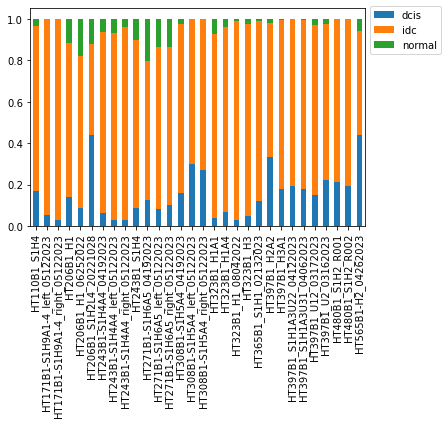

In [227]:
frac_df.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, .9))

In [234]:
## calculate fraction of DCIS vs. IDC in each sample
from collections import Counter
df = type_to_combined['region'].copy()
order = sorted(set(df['predicted_label']))

data = []
for sample in samples:
    f = df[df['sample']==sample]
    
    counts = Counter(f['predicted_label'])
#     row = np.asarray([counts.get(x, 0) for x in order], dtype=float)
    row = f[['area', 'predicted_label']].groupby('predicted_label').sum()['area']
    row /= row.sum()
    data.append(row)

frac_df = pd.DataFrame(data=data, columns=order, index=samples)
frac_df
    

dcis       idc    normal
HT110B1_S1H4                     0.223470  0.735421  0.041110
HT171B1-S1H9A1-4_left_05122023   0.337526  0.662474       NaN
HT171B1-S1H9A1-4_right_05122023  0.307518  0.692482       NaN
HT206B1_H1                       0.418075  0.564522  0.017403
HT206B1_H1_06252022              0.287720  0.678514  0.033766
HT206B1_S1H2L4_20221028          0.421955  0.554802  0.023243
HT243B1-S1H4A4_04192023          0.039690  0.866806  0.093504
HT243B1-S1H4A4_left_05122023     0.042038  0.881788  0.076174
HT243B1-S1H4A4_right_05122023    0.046767  0.819899  0.133333
HT243B1_S1H4                     0.225246  0.679916  0.094837
HT271B1-S1H6A5_04192023          0.322561  0.601860  0.075579
HT271B1-S1H6A5_left_05122023     0.101927  0.808865  0.089208
HT271B1-S1H6A5_right_05122023    0.170391  0.727624  0.101985
HT308B1-S1H5A4_04192023          0.140667  0.856309  0.003025
HT308B1-S1H5A4_left_05122023     0.137349  0.862651       NaN
HT308B1-S1H5A4_right_05122023    0.159706  0.840294       NaN
HT323B1_H1A1                     0.094803  0.802579  0.102618
HT323B1_H1A4                     0.220332  0.728130  0.051538
HT323B1_H1_08042022              0.184669  0.807248  0.008083
HT323B1_H3                       0.138364  0.829402  0.032235
HT365B1_S1H1_02132023            0.373539  0.625583  0.000878
HT397B1_H2A2                     0.692170  0.296841  0.010989
HT397B1_H3A1                     0.399972  0.599472  0.000556
HT397B1_S1H1A3U22_04122023       0.197999  0.802001       NaN
HT397B1_S1H1A3U31_04062023       0.191491  0.807296  0.001212
HT397B1_U12_03172023             0.428113  0.565993  0.005894
HT397B1_U2_03162023              0.489222  0.507496  0.003282
HT480B1_S1H2_R001                0.404723  0.595277       NaN
HT480B1_S1H2_R002                0.361456  0.637293  0.001251
HT565B1-H2_04262023              0.777181  0.216075  0.006744

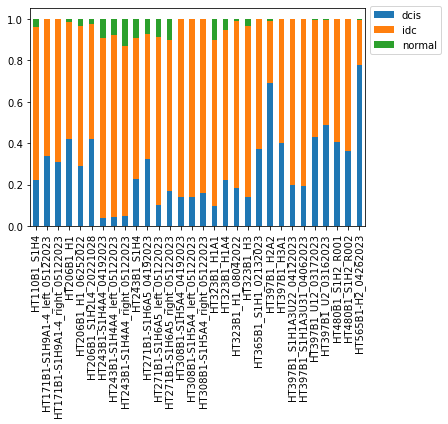

In [235]:
frac_df.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, .9))

In [151]:
samples

['HT110B1_S1H4',
 'HT171B1-S1H9A1-4_left_05122023',
 'HT171B1-S1H9A1-4_right_05122023',
 'HT206B1_H1',
 'HT206B1_H1_06252022',
 'HT206B1_S1H2L4_20221028',
 'HT243B1-S1H4A4_04192023',
 'HT243B1-S1H4A4_left_05122023',
 'HT243B1-S1H4A4_right_05122023',
 'HT243B1_S1H4',
 'HT271B1-S1H6A5_04192023',
 'HT271B1-S1H6A5_left_05122023',
 'HT271B1-S1H6A5_right_05122023',
 'HT308B1-S1H5A4_04192023',
 'HT308B1-S1H5A4_left_05122023',
 'HT308B1-S1H5A4_right_05122023',
 'HT323B1_H1A1',
 'HT323B1_H1A4',
 'HT323B1_H1_08042022',
 'HT323B1_H3',
 'HT365B1_S1H1_02132023',
 'HT397B1_H2A2',
 'HT397B1_H3A1',
 'HT397B1_S1H1A3U22_04122023',
 'HT397B1_S1H1A3U31_04062023',
 'HT397B1_U12_03172023',
 'HT397B1_U2_03162023',
 'HT480B1_S1H2_R001',
 'HT480B1_S1H2_R002',
 'HT565B1-H2_04262023']

In [152]:
sorted(type_to_combined['region'].columns)

['area',
 'c1',
 'c2',
 'cell_type_fraction_B cell',
 'cell_type_fraction_CD4 T cell',
 'cell_type_fraction_CD8 T cell',
 'cell_type_fraction_Endothelial',
 'cell_type_fraction_Epithelial',
 'cell_type_fraction_Immune',
 'cell_type_fraction_Macrophage - M1',
 'cell_type_fraction_Stroma',
 'cell_type_fraction_Treg',
 'cell_type_fraction_Unlabeled',
 'col',
 'compactness',
 'marker_fraction_CD11b',
 'marker_fraction_CD163',
 'marker_fraction_CD20',
 'marker_fraction_CD31',
 'marker_fraction_CD3e',
 'marker_fraction_CD4',
 'marker_fraction_CD45',
 'marker_fraction_CD68',
 'marker_fraction_CD8',
 'marker_fraction_CK14',
 'marker_fraction_CK17',
 'marker_fraction_CK5',
 'marker_fraction_E-cadherin',
 'marker_fraction_FOXP3',
 'marker_fraction_Ki67',
 'marker_fraction_Pan-Cytokeratin',
 'marker_fraction_Podoplanin',
 'marker_fraction_SMA',
 'marker_intensity_BCA1',
 'marker_intensity_Bap1',
 'marker_intensity_CD11b',
 'marker_intensity_CD11c',
 'marker_intensity_CD138',
 'marker_intensity_CD